# Looking For the Large Spacing, $\delta \nu$, And Planets

This notebook arose out of the difficulties I was having with getting a generic CARMA fit to run to converge successfully.  I decided to do fits that start simple, and then add complexity.  I began with simple periodogram models, moved to Keplerian planetary fits (with weighted least-squares---that is, white Gaussian noise), then to Keplerian fits with AR(1) noise models (so correlated noise, with exponential correlation function), and finally Keplerian fits with AR(1) noise plus an increasing number of modes around the $\nu_\mathrm{max}$ found in other studies.

Add our codebase to the `LOAD_PATH`, and load various libraries.

In [1]:
push!(LOAD_PATH, "../code")

3-element Array{Any,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.6"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.6"      
 "../code"                                                         

In [2]:
using Aldebaran
using CARMA
using Ensemble
using HDF5
using CARMAKepler
using Optim
using Periodogram
using PyCall
using PyPlot

import Base.convert

@pyimport seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

@pyimport corner

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] @vectorize_2arg(::ANY, ::ANY) at ./deprecated.jl:339
 [3] include_from_node1(::String) at ./loading.jl:576
 [4] include(::String) at ./sysimg.jl:14
 [5] include_from_node1(::String) at ./loading.jl:576
 [6] eval(::Module, ::Any) at ./boot.jl:235
 [7] _require(::Symbol) at ./loading.jl:490
 [8] require(::Symbol) at ./loading.jl:405
 [9] include_from_node1(::String) at ./loading.jl:576
 [10] eval(::Module, ::Any) at ./boot.jl:235
 [11] _require(::Symbol) at ./loading.jl:490
 [12] require(::Symbol) at ./loading.jl:405
 [13] include_from_node1(::String) at ./loading.jl:576
 [14] eval(::Module, ::Any) at ./boot.jl:235
 [15] _require(::Symbol) at ./loading.jl:490
 [16] require(::Symbol) at ./loading.jl:405
 [17] include_string(::String, ::String) at ./loading.jl:522
 [18] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [19] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /

## Load The Data

We want to load timeseries of *all* data (`ts`, `ys`, `dys`) and also all the data before the SONG observations: (`ts_ps`, `ys_ps`, `dys_ps`).

In [3]:
ts, ys, dys = Aldebaran.load_timeseries();
ts_ps, ys_ps, dys_ps = Aldebaran.load_timeseries(before_song=true, song=false);

In [4]:
tmed = median(vcat(ts...))
ts = [t-tmed for t in ts];

In [5]:
tmin = minimum([minimum(t) for t in ts])
tmax = maximum([maximum(t) for t in ts])
T = tmax - tmin
muHz = 1e-6*(3600.0*24.0);

## Periodogram Models

I wrote some code that simultaneously fits the offset (mean value) in each data set and an arbitrary number of periodic components.  Let's look at the periodogram over a wide range of frequencies, log-spaced:

In [6]:
fs = exp.(collect(linspace(log(1e-3), log(5*muHz), 10000)))
coeffs = [Periodogram.pgram(ts, ys, dys, f) for f in fs]
rms_amps = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs];

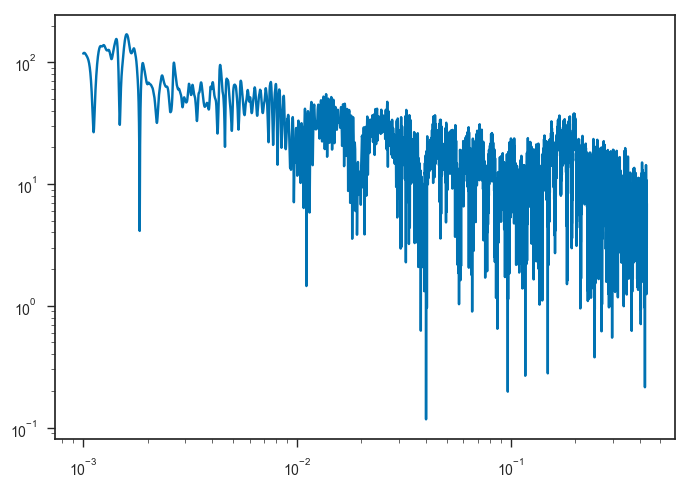

In [7]:
plot(fs, rms_amps)
xscale("log")
yscale("log")

The overall maximum power should (per [Hatzes, et al. (2015)](http://dx.doi.org/10.1051/0004-6361/201425519)) be at the Keplerian orbital period; in that work, $P = 628.96 \pm 0.90 \, \mathrm{d}$.

In [8]:
Pkep = 1.0/fs[indmax(rms_amps)]

626.6823397842544

There seems to be a "bump" at higher frequency; let's zoom in, while removing the Keplerian period:

In [9]:
fs_zoom = collect(linspace(1*muHz, 5*muHz, 10000))
coeffs_zoom = [Periodogram.pgram(ts, ys, dys, [1.0/Pkep, f]) for f in fs_zoom]
rms_amps_zoom = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs_zoom];

And picking out all the time samples that are above an (arbitrary) threshold, we find the following peaks:

In [10]:
rms_peak_threshold = 27
peak_spacing_cut = 1e-3
fs_peaks = fs_zoom[rms_amps_zoom .> rms_peak_threshold]
freqs = []
f = []
for i in 2:size(fs_peaks, 1)-1
    push!(f, fs_peaks[i])
    if fs_peaks[i+1] - fs_peaks[i] > peak_spacing_cut
        push!(freqs, f)
        f = []
    end
end
push!(freqs, f)
freqs = [mean(f) for f in freqs]

5-element Array{Float64,1}:
 0.167594
 0.174191
 0.177549
 0.187652
 0.197549

The peak pattern should be $l = 0$, followed by $l = 1$, followed by $l = 0$, ....  (Thanks, Guy!)  So:

In [11]:
dNu_estimates = vcat(diff(freqs[2:2:end]/muHz), diff(freqs[1:2:end])/muHz)

3-element Array{Float64,1}:
 0.155799
 0.115214
 0.231488

In [12]:
println(@sprintf("Mean of separation between peak freqs is %.3g +/- %.2g muHz", mean(dNu_estimates), std(dNu_estimates)/sqrt(length(dNu_estimates))))

Mean of separation between peak freqs is 0.168 +/- 0.034 muHz


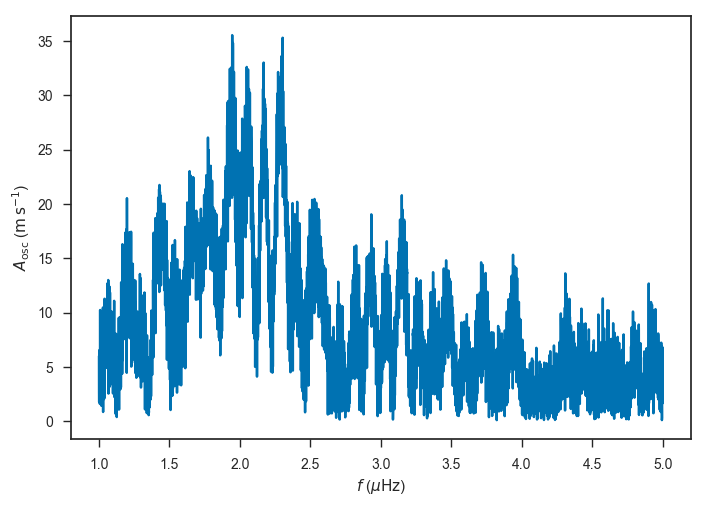

PyObject <matplotlib.text.Text object at 0x155033c18>

In [13]:
plot(fs_zoom/muHz, rms_amps_zoom)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

And with the threshold we chose and the peaks we found labelled:

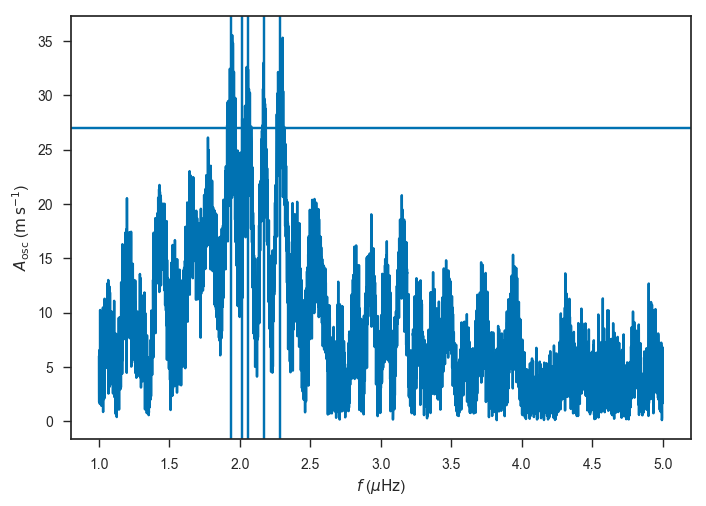

PyObject <matplotlib.text.Text object at 0x15858b588>

In [14]:
plot(fs_zoom/muHz, rms_amps_zoom)
axhline(rms_peak_threshold)
for f in freqs
    axvline(f/muHz)
end
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

What does this plot look like pre-SONG?  Not nearly as nice:

In [15]:
coeffs_zoom_ps = [Periodogram.pgram(ts_ps, ys_ps, dys_ps, [1.0/Pkep, f]) for f in fs_zoom]
rms_amps_zoom_ps = sqrt.([c[end-1]^2 + c[end]^2 for c in coeffs_zoom_ps]);

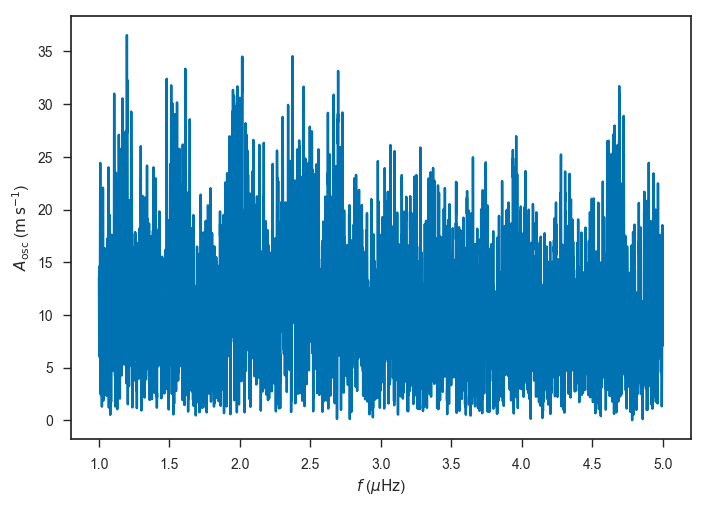

PyObject <matplotlib.text.Text object at 0x1595fa2e8>

In [16]:
plot(fs_zoom/muHz, rms_amps_zoom_ps)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{osc}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

## Keplerian Orbits

Now let's see if we can find a good orbital solution:

In [23]:
post = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 0, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 5*muHz, 1000.0);
p0 = CARMAKepler.to_params(post, zeros(CARMAKepler.nparams(post)))

CARMAKepler.MultiEpochParams([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25], 899.9957168654438, 650.0, NaN, NaN, 0.5, [899.996], [0.00217886], Float64[], Float64[], Float64[])

Find the optimum period and phase from the periodogram:

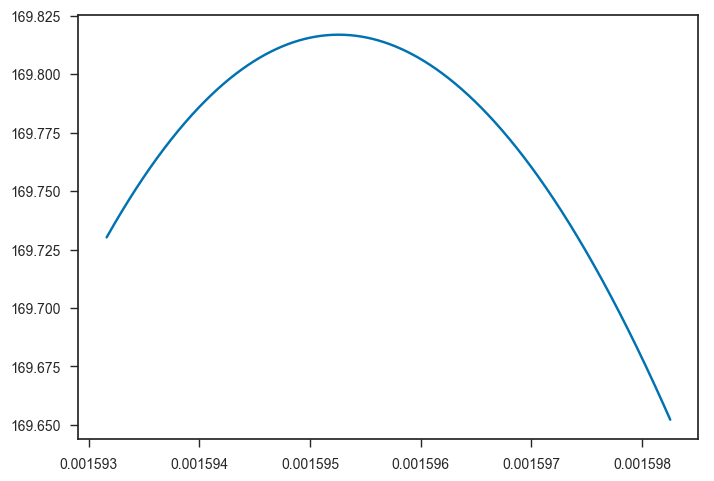

2-element Array{Float64,1}:
 149.074
 -81.331

In [18]:
fs_kep = collect(linspace(1.0/(Pkep+1), 1.0/(Pkep-1), 1000))
coeffs_kep = [Periodogram.pgram(ts, ys, dys, f) for f in fs_kep]
rmss_kep = [sqrt(c[end-1]^2 + c[end]^2) for c in coeffs_kep]
plot(fs_kep, rmss_kep)
Pkep = 1.0/fs_kep[indmax(rmss_kep)]
rms_kep = maximum(rmss_kep)
ckep = coeffs_kep[indmax(rmss_kep)]
Akep, Bkep = coeffs_kep[indmax(rmss_kep)][end-1:end]

A good initial guess:

In [19]:
p0.mu = ckep[1:end-2]
p0.nu = ones(size(ts, 1))
p0.K = 136.1 #sqrt(Akep^2 + Bkep^2) 
p0.P = Pkep
p0.ecosw = 0.01
p0.esinw = 0.01

p0.chi = atan2(Bkep, Akep)/(2*pi)
if p0.chi < 0.0
    p0.chi += 1
end

p0.drw_rms = [850.0]
p0.drw_rate = [0.07]

p0.osc_rms = Float64[]
p0.osc_freq = Float64[]
p0.osc_Q = Float64[]

0-element Array{Float64,1}

Below is code that does weighted least-squares fits with Keplerian motion (i.e. it assumes that the noise term is white, Gaussian, with stated observational uncertainties).  This is obviously a bad model (check the fits against the data below), but a reasonable starting point:

In [17]:
type KeplerParams
    mu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0

function KeplerParams(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    
    i = nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerParams(mu, K, P, e, w, chi)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerParams)
    x = zeros(size(p.mu,1) + 5)
    x[1:size(p.mu, 1)] = p.mu
    
    i = size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    
    x
end

function log_kepler_prior(x::Array{Float64, 1})
    log_kepler_prior(KeplerParams(x))
end
function log_kepler_prior(p::KeplerParams)
    # Flat prior on everything
    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp
end

function log_kepler_likelihood(x::Array{Float64, 1})
    log_kepler_likelihood(KeplerParams(x))
end
function log_kepler_likelihood(p::KeplerParams)
    ll = 0.0
    
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            resid = post.ys[i][j] - p.mu[i] - rv
            
            ll -= 0.5*resid*resid/(post.dys[i][j]*post.dys[i][j])
        end
    end
    
    ll
end

function log_kepler_posterior(x::Array{Float64, 1})
    log_kepler_posterior(KeplerParams(x))
end
function log_kepler_posterior(p::KeplerParams)
    lp = log_kepler_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_likelihood(p)
    end
end

log_kepler_posterior (generic function with 2 methods)

Start at a good guess for the Keplerian parameters:

In [14]:
pk = KeplerParams(zeros(size(p0.mu, 1) + 5)+0.01)

pk.mu = p0.mu
pk.K = p0.K
pk.P = p0.P
pk.e = sqrt(p0.ecosw*p0.ecosw + p0.esinw*p0.esinw)
pk.omega = atan2(p0.esinw, p0.ecosw)
pk.chi = p0.chi

0.9205117813591597

In [15]:
xk = convert(Array{Float64, 1}, pk)

13-element Array{Float64,1}:
   -37.1854  
    24.0642  
     3.98172 
   -57.8592  
    11.1452  
     3.80603 
     1.57845 
 54300.1     
   136.1     
   626.858   
     0.010002
     0.010002
     2.44932 

Optimize a bit (run this cell and the next in a loop if necessary):

In [73]:
res = Optim.optimize(x -> -log_kepler_likelihood(x), xk, NelderMead(), Optim.Options(iterations=10000))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-37.18539941947494,24.064184541552102, ...]
 * Minimizer: [-31.490004453303918,15.628888186937612, ...]
 * Minimum: 1.389676e+05
 * Iterations: 3811
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 5627

In [74]:
xmin = Optim.minimizer(res)
pmin = KeplerParams(xmin)

KeplerParams([-31.49, 15.6289, -3.37295, -83.1213, 6.92604, -21.6193, 0.0783711, 54273.2], 171.134176110376, 627.3397783199376, 0.2598874187223338, -0.4528522754526715, 0.8902224267953238)

What does the optimum fit look like in data space?  Pretty bad, really.  Clearly there are other noise sources in this data set than implied by the errobars.

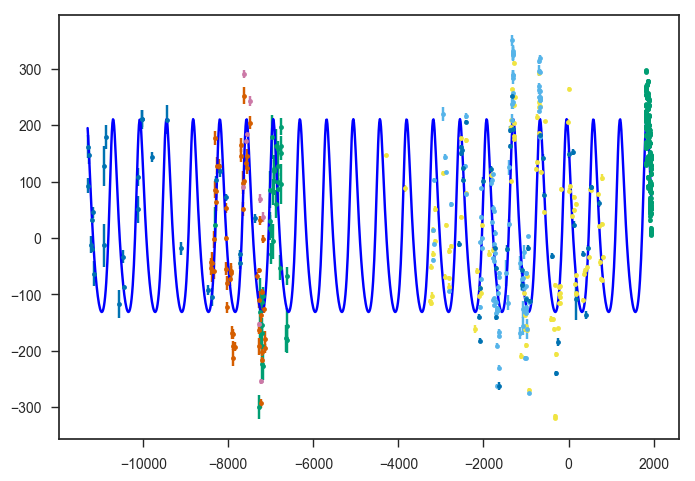

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1594fe128>

In [76]:
for i in eachindex(post.ts)
    errorbar(post.ts[i], post.ys[i]-pmin.mu[i], post.dys[i], fmt=".")
end
tsp = collect(linspace(tmin, tmax, 1000))
rvs = [Kepler.rv(t, pmin.K, pmin.P, pmin.e, pmin.omega, pmin.chi) for t in tsp]
plot(tsp, rvs, "-b")

Set up an ensemble of points about the maximum:

In [84]:
xs = broadcast((+), xmin, 1e-5*randn(size(xmin,1), 128))

13×128 Array{Float64,2}:
   -31.49        -31.49         -31.49       …    -31.49        -31.49    
    15.6289       15.6289        15.6289           15.6289       15.6289  
    -3.37294      -3.37295       -3.37294          -3.37298      -3.37294 
   -83.1213      -83.1213       -83.1213          -83.1213      -83.1213  
     6.92603       6.92604        6.92604           6.92603       6.92604 
   -21.6193      -21.6193       -21.6193     …    -21.6193      -21.6193  
     0.078377      0.0783588      0.0783838         0.078359      0.07838 
 54273.2       54273.2        54273.2           54273.2       54273.2     
   171.134       171.134        171.134           171.134       171.134   
   627.34        627.34         627.34            627.34        627.34    
     0.250608      0.250617       0.250634   …      0.250625      0.250608
    -0.121928     -0.121941      -0.12195          -0.121931     -0.121933
     2.09301       2.09301        2.09301           2.09303       2.09303 

In [85]:
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_posterior)

128-element Array{Float64,1}:
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
  ⋮       
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5
 -1.3897e5

And run an MCMC to a certain number of effective samples (128 effective *ensembles* gives `128*128=16384` effective samples).

In [86]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_posterior, 128, callback=EnsembleSampler.basic_callback)

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-138970.2, -138976.0, 7.6)
    ACLs are [47.1,44.3,77.1,75.8,36.7,54.9,33.4,54.8,39.4,Inf,58.1,46.9,43.9]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [35.7,62.5,30.6,30.6,29.7,67.8,40.5,35.6,25.1,42.0,63.1,Inf,43.1]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-138970.5, -138976.7, 6.5)
    ACLs are [23.6,89.6,20.1,22.3,18.5,44.2,13.5,38.4,45.4,33.0,43.9,15.5,25.3]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-138970.8, -138976.7, 6.5)
    ACLs are [10.5,14.8,20.1,25.7,19.5,27.0,14.5,21.8,12.5,36.5,11.5,34.8,31.0]
Advanced for 16384 steps (thin = 16); (max, mean, var)(log(pi)) = (-138970.7, -138976.7, 6.5)
    ACLs are [13.1,8.8,14.7,9.3,7.0,10.4,12.0,15.6,15.0,10.8,12.7,8.3,7.3]
Advanced for 32768 steps (thin = 32); (max, mean, var)(log(pi)) = (-138970.6, -138976.7, 6.5)
    ACLs are [6.2,5.7,4.8,5.3,4.9,4.7,6.5,4.5,5.0,5

([-34.435 -32.0391 … -34.3795 -29.0583; 14.9909 15.8239 … 15.1805 21.5342; … ; -0.117794 -0.120721 … -0.117328 -0.122577; 2.10215 2.10125 … 2.11384 2.09273]

[-33.5856 -32.0096 … -32.2643 -30.4439; 19.6287 14.3392 … 13.5513 24.0578; … ; -0.119342 -0.12132 … -0.118674 -0.121436; 2.09911 2.09988 … 2.10535 2.09309]

[-33.2239 -30.5872 … -31.9274 -30.8013; 18.4623 14.8671 … 14.9329 19.949; … ; -0.120713 -0.119159 … -0.117136 -0.121363; 2.09722 2.09747 … 2.10683 2.09331]

...

[-34.7406 -30.4471 … -29.0208 -28.2412; 13.3078 20.9638 … 19.9829 14.4674; … ; -0.121147 -0.11943 … -0.1234 -0.12376; 2.10603 2.0978 … 2.08517 2.08034]

[-32.7929 -31.2705 … -29.9117 -28.1555; 16.5142 21.2999 … 18.8426 15.306; … ; -0.121034 -0.120542 … -0.124608 -0.122696; 2.1068 2.09395 … 2.08358 2.08225]

[-31.9601 -30.8698 … -29.3612 -29.5757; 16.6291 21.6491 … 21.8993 15.215; … ; -0.122013 -0.121389 … -0.123326 -0.121024; 2.09658 2.08654 … 2.09303 2.09695], [-1.38981e5 -1.38979e5 … -1.38976e5 -1.38975e5; -1.38975e

...an array of useful parameters instead of the $\mathbb{R}^n$ mapping we use:

In [89]:
ps = [KeplerParams(xs[:,j,k]) for j in 1:size(xs,2) for k in 1:size(xs, 3)];

Run this cell to save the parameter array into an HDF5 file:

In [91]:
h5open("pure-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in ps]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in ps]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in ps]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in ps]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in ps]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in ps]
end;

And run this cell to re-load a previously-saved parameter file:

In [18]:
h5open("pure-kepler.h5", "r") do f
    global mus = read(f, "mu")
    global Ks = read(f, "K")
    global Ps = read(f, "P")
    global es = read(f, "e")
    global omegas = read(f, "omega")
    global chis = read(f, "chi")
end
ps = [KeplerParams(mus[i,:], Ks[i], Ps[i], es[i], omegas[i], chis[i]) for i in eachindex(Ks)];

Some distributions of orbital parameters (we find a very small uncertainty on the period, considerably smaller than reported in [Hatzes, et al. (2015)](http://dx.doi.org/10.1051/0004-6361/201425519).

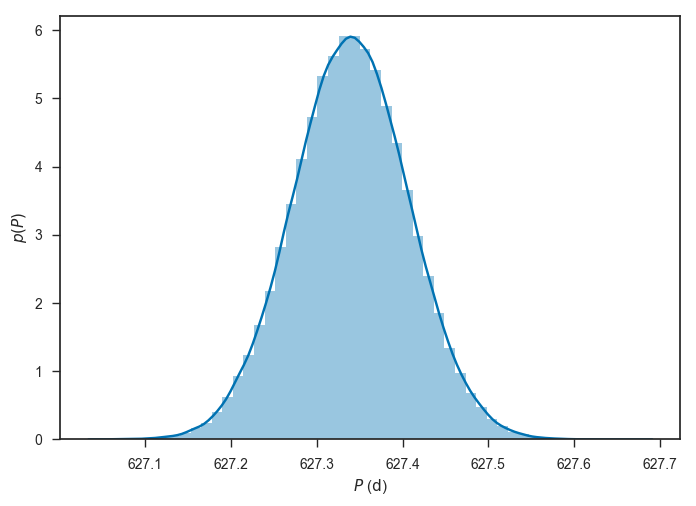

P = 627.340 +/- 0.067 d


In [19]:
sns.distplot([p.P for p in ps])
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")
println(@sprintf("P = %.3f +/- %.3f d", mean([p.P for p in ps]), std([p.P for p in ps])))

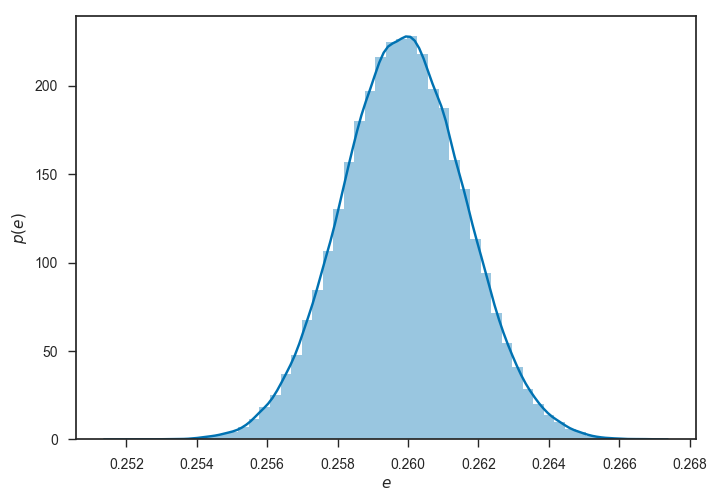

e = 0.2599 +/- 0.0017


In [20]:
sns.distplot([p.e for p in ps])
xlabel(L"$e$")
ylabel(L"$p(e)$")
println(@sprintf("e = %.4f +/- %.4f", mean([p.e for p in ps]), std([p.e for p in ps])))

Plotting 10 random trajectories in grey; can't hardly see the variation.

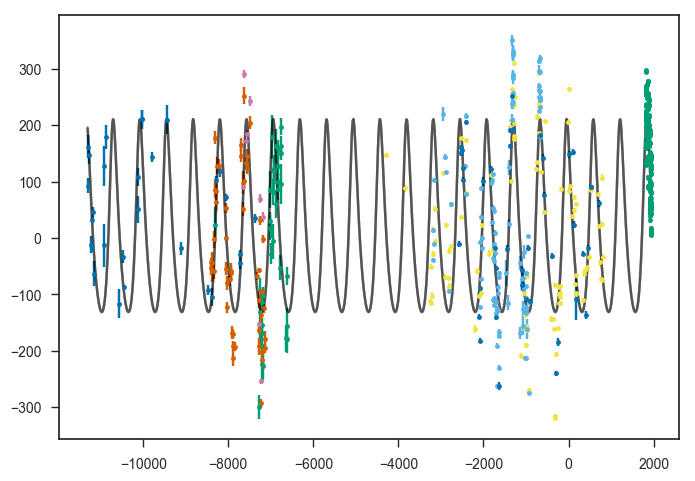

In [24]:
mu_mu = vec(mean(hcat([p.mu for p in ps]...), 2))
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-mu_mu[i], dys[i], fmt=".")
end
ts_plot = collect(linspace(tmin, tmax, 1000))
for i in 1:10
    j = rand(1:size(ps, 1))
    p = ps[j]
    rvs = [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts_plot]
    plot(ts_plot, rvs, color="k", alpha=0.1)
end

## Keplerian, with AR(1) Noise Model

The white noise model is so obviously bad (we miss the data points above by *tens* of $\sigma$s), let's try introducing a simple AR(1) (exponential correlation function) noise model:

In [24]:
type KeplerAR1Params
    mu::Array{Float64, 1}
    nu::Array{Float64, 1}
    K::Float64
    P::Float64
    e::Float64
    omega::Float64
    chi::Float64
    sigma::Float64
    tau::Float64
end

Pmin = 620.0
Pmax = 640.0
Kmin = 10.0
Kmax = 1000.0
dt_min = minimum(diff(sort(post.allts)))
T = tmax-tmin

function KeplerAR1Params(x::Array{Float64, 1})
    nseg = size(ts, 1)
    
    mu = x[1:nseg]
    nu = Parameterizations.bounded_value(x[nseg+1:2*nseg], 0.5, 2.0)
    
    i = 2*nseg+1
    
    K = x[i]
    i = i+1
    
    P = x[i]
    i = i+1
    
    ecosw, esinw = Parameterizations.unit_disk_value(x[i:i+1])
    i = i+2
    
    chi = Parameterizations.bounded_value(x[i], 0.0, 1.0)
    i = i+1
    
    sigma = exp(x[i])
    i = i+1
    
    tau = exp(x[i])
    i = i+1
    
    e = sqrt(ecosw*ecosw + esinw*esinw)
    w = atan2(esinw, ecosw)
    
    KeplerAR1Params(mu, nu, K, P, e, w, chi, sigma, tau)
end

function convert(::Type{Array{Float64, 1}}, p::KeplerAR1Params)
    x = zeros(2*size(p.mu,1) + 7)
    x[1:size(p.mu, 1)] = p.mu
    x[size(p.mu,1)+1:2*size(p.mu,1)] = Parameterizations.bounded_param(p.nu, 0.5, 2.0)
    
    i = 2*size(p.mu,1) + 1
    
    x[i] = p.K
    i = i+1
    
    x[i] = p.P
    i = i+1
    
    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    x[i:i+1] = Parameterizations.unit_disk_param(z)
    i = i+2
    
    x[i] = Parameterizations.bounded_param(p.chi, 0.0, 1.0)
    i = i+1
    
    x[i] = log(p.sigma)
    i = i+1
    
    x[i] = log(p.tau)
    i = i+1

    x
end

function log_kepler_ar1_prior(x::Array{Float64, 1})
    log_kepler_ar1_prior(KeplerAR1Params(x))
end
function log_kepler_ar1_prior(p::KeplerAR1Params)    
    lp = 0.0

    ecosw = p.e*cos(p.omega)
    esinw = p.e*sin(p.omega)
    z = [ecosw, esinw]
    pp = Parameterizations.unit_disk_param(z)
    lp += Parameterizations.unit_disk_logjac(z, pp)
    
    lp += Parameterizations.bounded_logjac(p.chi, Parameterizations.bounded_param(p.chi, 0.0, 1.0), 0.0, 1.0)
    
    lp -= sum(log.(p.nu)) # Flat in log nu
    lp += Parameterizations.bounded_logjac(p.nu, Parameterizations.bounded_param(p.nu, 0.5, 2.0), 0.5, 2.0)
    
    lp
end

function log_kepler_ar1_likelihood(x::Array{Float64, 1})
    log_kepler_ar1_likelihood(KeplerAR1Params(x))
end
function log_kepler_ar1_likelihood(p::KeplerAR1Params)
    ll = 0.0
    
    ts = Float64[]
    resid = Float64[]
    dys = Float64[]
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            r = post.ys[i][j] - p.mu[i] - rv
            
            push!(ts, post.ts[i][j])
            push!(resid, r)
            push!(dys, post.dys[i][j]*p.nu[i])
        end
    end
    
    inds = sortperm(ts)
    ts = ts[inds]
    resid = resid[inds]
    dys = dys[inds]
    
    kpost = Kalman.AR1KalmanPosterior(ts, resid, dys)
    kparams = Kalman.AR1KalmanParams(0.0, p.sigma, 1.0, p.tau)
    
    Kalman.log_likelihood(kpost, kparams)
end

function log_kepler_ar1_posterior(x::Array{Float64, 1})
    log_kepler_ar1_posterior(KeplerAR1Params(x))
end
function log_kepler_ar1_posterior(p::KeplerAR1Params)
    lp = log_kepler_ar1_prior(p)
    
    if lp == -Inf
        lp
    else
        lp + log_kepler_ar1_likelihood(p)
    end
end

function kepler_ar1_white_residuals(x::Array{Float64, 1})
    kepler_ar1_white_residuals(KeplerAR1Params(x))
end
function kepler_ar1_white_residuals(p::KeplerAR1Params)
    ts = Float64[]
    ys = Float64[]
    dys = Float64[]
    
    for i in eachindex(post.ts)
        for j in eachindex(post.ts[i])
            rv = Kepler.rv(post.ts[i][j], p.K, p.P, p.e, p.omega, p.chi)
            r = post.ys[i][j] - p.mu[i] - rv
            
            push!(ts, post.ts[i][j])
            push!(ys, r)
            push!(dys, post.dys[i][j]*p.nu[i])
        end
    end
    
    inds = sortperm(ts)
    ts = ts[inds]
    ys = ys[inds]
    dys = dys[inds]
    
    filt = Kalman.AR1KalmanFilter(0.0, p.sigma*p.sigma, p.tau) # Filter wants variance
    wrs = Kalman.whiten(filt, ts, ys, dys)
    
    rs = [zeros(size(y,1)) for y in post.ys]
    k = 1
    for i in eachindex(rs)
        for j in eachindex(rs[i])
            rs[i][j] = wrs[inds[k]]
            k = k+1
        end
    end
    
    rs
end

kepler_ar1_white_residuals (generic function with 2 methods)

A good guess at the parameters (from the earlier fits, plus staring at the periodogram):

In [26]:
pkep = ps[rand(1:size(ps,1))]
par = KeplerAR1Params(zeros(2*size(ts, 1) + 8))

par.mu = pkep.mu
par.nu = ones(size(ts, 1))
par.K = pkep.K
par.P = pkep.P
par.e = pkep.e
par.omega = pkep.omega
par.chi = pkep.chi
par.sigma = 50.0
par.tau = 1000.0

1000.0

Find the optimum.  Change `xmin` below to `convert(Array{Float64, 1}, par)` to initialise.

In [148]:
res = Optim.optimize(x -> -log_kepler_ar1_posterior(x), xmin, NelderMead(), Optim.Options(iterations=10000))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] #157 at ./In[148]:1 [inlined]
 [6] NLSolversBase.NonDifferentiable(::##157#158, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/NLSolversBase/src/objective_types.jl:23
 [7] optimize at /Users/farr/.julia/v0.6/Optim/src/multivariate/optimize/interface.jl:78 [inlined]
 [8] optimize(::Function, ::Array{Float64,1}, ::Optim.NelderMead{Optim.AffineSimplexer,Optim.AdaptiveParameters}, ::Optim.Options{Float64,Void}) at /Users/farr/.julia/v0.6/Optim/src/multivariate/optimize/interface.jl:74
 [9] include_string(::String, ::String) at ./loading.jl:522
 [10] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [11] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_reque

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [8.89590556577201,-22.440088504258902, ...]
 * Minimizer: [8.911662936307032,-22.43883254430412, ...]
 * Minimum: 3.049802e+03
 * Iterations: 1064
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 2261

In [149]:
xmin = Optim.minimizer(res)
pmin = KeplerAR1Params(xmin)

KeplerAR1Params([8.91166, -22.4388, 14.7584, -26.1186, -0.480442, -5.1328, 2.60492, 54311.4], [1.02958, 1.26562, 0.584929, 0.671119, 1.04899, 1.4098, 0.960727, 0.587233], 138.21882748749786, 628.6209108171945, 0.0990958230347969, -1.0425083104511876, 0.8088767380138208, 90.26724767086154, 6.122883742183516)

In [152]:
xs = broadcast((+), xmin, 1e-2*randn(size(xmin,1), 128))
lnprobs = EnsembleSampler.lnprobs(xs, log_kepler_ar1_posterior);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[152], in expression starting on line 2


A generic callback that saves the current state of the chain in a file in `/tmp/`:

In [167]:
function cb(pts, lnprobs, n, thin)
     h5open("/tmp/state.save.h5.temp", "w") do f
        f["pts", "shuffle", (), "compress", 3] = pts
    end
    mv("/tmp/state.save.h5.temp", "/tmp/state.save.h5", remove_destination=true)
    EnsembleSampler.basic_callback(pts, lnprobs, n, thin)
    println(@sprintf("    acceptance fraction = %.3f", mean(Acor.acceptance_rate(pts, thin))))
    flush(STDOUT)
end

cb (generic function with 1 method)

Run an MCMC (it takes overnight; I interrupted it when there were a lot, but not quite 16384, independent samples).

In [183]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, log_kepler_ar1_posterior, 128, callback=cb)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_kepler_ar1_prior(::KeplerAR1Params) at ./In[142]:98
 [4] log_kepler_ar1_posterior(::KeplerAR1Params) at ./In[142]:138
 [5] lnprobs(::Array{Float64,2}, ::#log_kepler_ar1_posterior) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] update_half(::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:69
 [7] update(::Array{Float64,2}, ::Array{Float64,1}, ::Function) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:110
 [8] #run_mcmc#1(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:129
 [9] (::Ensemble.EnsembleSampler.#kw##run_mcmc)(::Array{Any,1}, ::Ensemble.EnsembleSampler.#run_mcmc, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at ./<missing>:0
 [10] #run_to_neff#4(:

Advanced for 1024 steps (thin = 1); (max, mean, var)(log(pi)) = (-3052.4, -3062.7, 14.6)
    ACLs are [60.5,52.9,54.0,47.7,Inf,62.6,65.4,Inf,34.1,Inf,Inf,101.7,Inf,Inf,49.8,59.8,77.5,Inf,Inf,Inf,Inf,Inf,Inf]
Advanced for 2048 steps (thin = 2); (max, mean, var)(log(pi)) = (-3052.7, -3062.7, 14.4)
    ACLs are [38.7,Inf,69.3,66.1,75.2,55.7,79.7,93.8,Inf,97.3,57.8,91.1,54.5,76.6,Inf,84.8,43.4,56.4,Inf,Inf,Inf,Inf,Inf]
Advanced for 4096 steps (thin = 4); (max, mean, var)(log(pi)) = (-3052.1, -3062.9, 14.8)
    ACLs are [51.9,69.9,Inf,65.4,93.7,52.5,49.4,83.5,82.0,84.5,90.9,45.3,50.9,Inf,56.8,Inf,32.6,46.8,71.2,42.6,97.7,53.4,51.0]
Advanced for 8192 steps (thin = 8); (max, mean, var)(log(pi)) = (-3052.6, -3062.9, 14.7)
    ACLs are [60.1,81.4,33.7,41.6,18.5,33.5,49.3,39.8,68.9,87.8,33.2,46.1,23.8,18.1,24.1,31.1,36.2,99.3,29.2,Inf,Inf,63.0,44.4]
Advanced for 16384 steps (thin = 16); (max, mean, var)(log(pi)) = (-3051.6, -3062.8, 14.7)
    ACLs are [27.3,18.0,25.4,28.8,47.1,61.9,Inf,36.7,27.6

LoadError: [91mInterruptException:[39m

Just check a chainplot, to see that things look OK (this really isn't ideal in high dimension; the ACL-based effective sample size works much better to assess convergence---B. Brewer has a paper where he makes this mistake, I think).

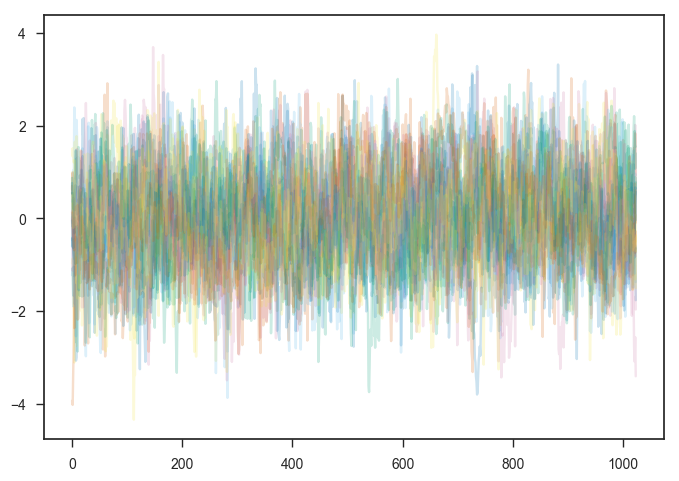

In [212]:
mus = reshape(mean(xs, 2), (size(xs,1), size(xs, 3)))
mu = mean(mus, 2)
sigmas = std(mus, 2)
for i in 1:size(xs, 1)
    plot(vec(mus[i,:]-mu[i])/sigmas[i], alpha=0.2)
end

Get a parameter array:

In [185]:
psar1 = KeplerAR1Params[]
for j in 1:size(xs, 2)
    for k in 1:size(xs, 3)
        push!(psar1, KeplerAR1Params(xs[:,j,k]))
    end
end

...and save it to an HDF5 file:

In [186]:
h5open("ar1-kepler.h5", "w") do f
    f["mu", "compress", 3, "shuffle", ()] = vcat([p.mu' for p in psar1]...)
    f["nu", "compress", 3, "shuffle", ()] = vcat([p.nu' for p in psar1]...)
    f["K", "compress", 3, "shuffle", ()] = [p.K for p in psar1]
    f["P", "compress", 3, "shuffle", ()] = [p.P for p in psar1]
    f["e", "compress", 3, "shuffle", ()] = [p.e for p in psar1]
    f["omega", "compress", 3, "shuffle", ()] = [p.omega for p in psar1]
    f["chi", "compress", 3, "shuffle", ()] = [p.chi for p in psar1]
    f["sigma", "compress", 3, "shuffle", ()] = [p.sigma for p in psar1]
    f["tau", "compress", 3, "shuffle", ()] = [p.tau for p in psar1]
end;

Run this to re-load the samples.

In [25]:
h5open("ar1-kepler.h5", "r") do f
    mus = read(f, "mu")
    nus = read(f, "nu")
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    sigmas = read(f, "sigma")
    taus = read(f, "tau")
    
    global psar1 = [KeplerAR1Params(mus[i,:], nus[i,:], Ks[i], Ps[i], es[i], omegas[i], chis[i], sigmas[i], taus[i]) for i in eachindex(Ps)]
end;

Now we compare between the white-noise model an the AR(1) model:

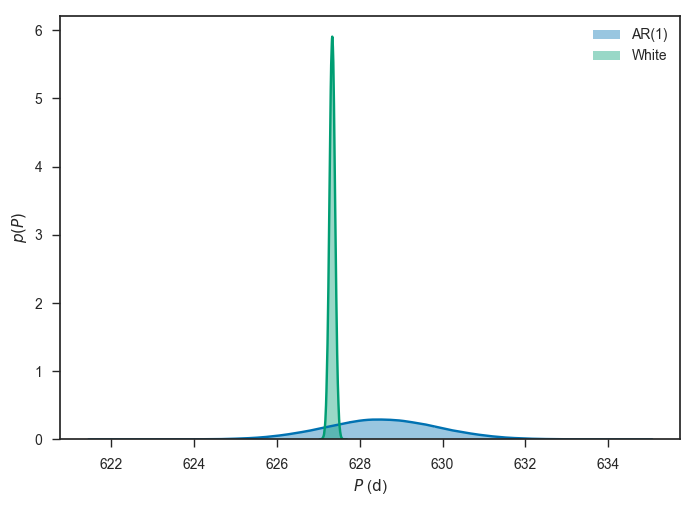

PyObject <matplotlib.legend.Legend object at 0x15c1440f0>

In [26]:
sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in ps], label="White")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")
legend(loc="best")

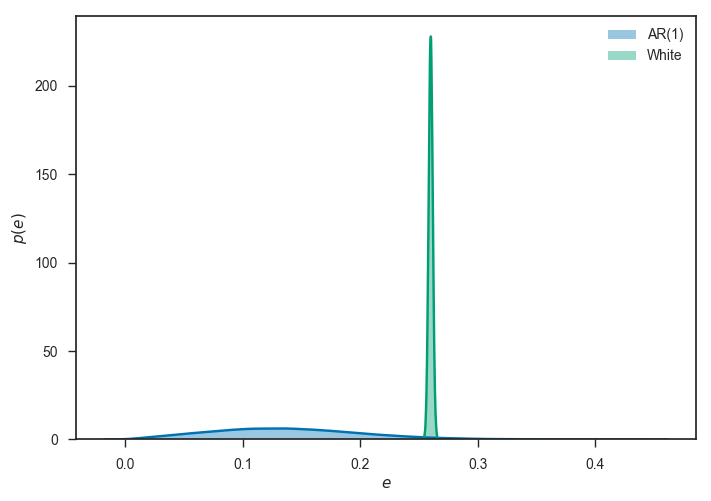

PyObject <matplotlib.legend.Legend object at 0x154db6278>

In [27]:
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in ps], label="White")
xlabel(L"$e$")
ylabel(L"$p(e)$")
legend(loc="best")

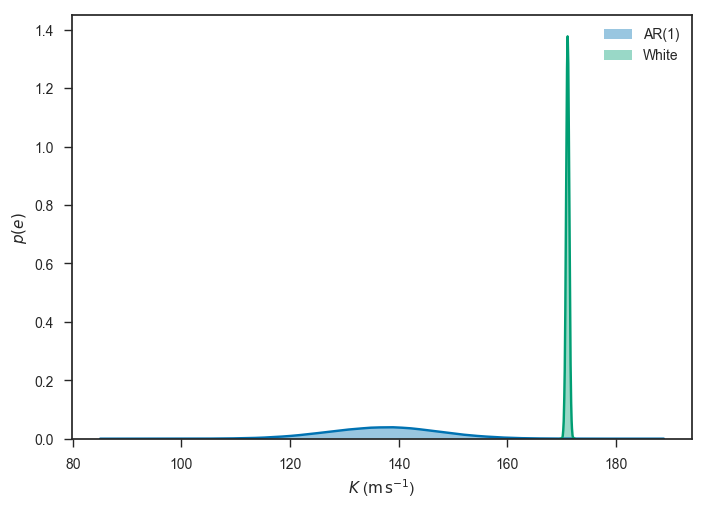

PyObject <matplotlib.legend.Legend object at 0x159cc1f60>

In [28]:
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in ps], label="White")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(e)$")
legend(loc="best")

$\nu$ is the scale factor on the quoted errrobars (bounded between 0.5 and 2).

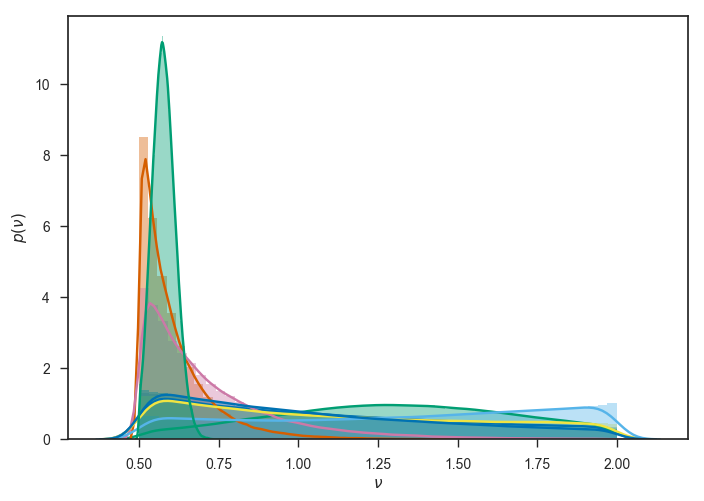

PyObject <matplotlib.text.Text object at 0x15f12fdd8>

In [31]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psar1])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

Given the short timescale here, probably the AR(1) model is locking onto the asteroseismology peak?

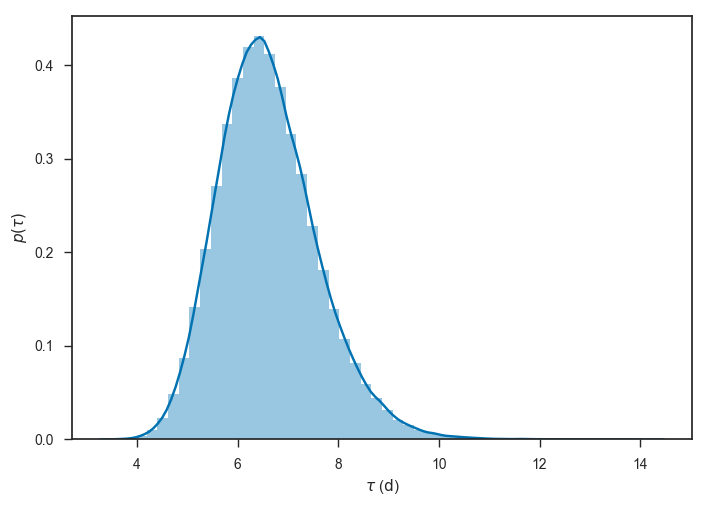

PyObject <matplotlib.text.Text object at 0x15f551c88>

In [32]:
sns.distplot([p.tau for p in psar1])
xlabel(L"$\tau$ ($\mathrm{d}$)")
ylabel(L"$p(\tau)$")

But at least the RMS in the AR(1) component is large, which helps to reduce the certainty on the Keplerian fit:

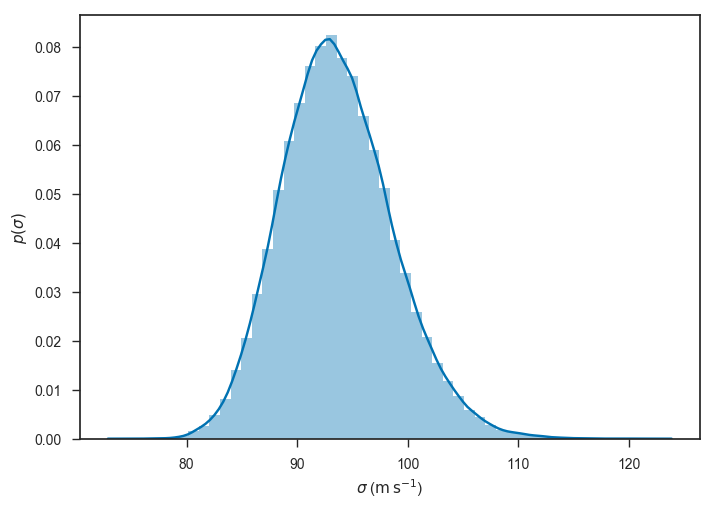

PyObject <matplotlib.text.Text object at 0x15fa0b2b0>

In [33]:
sns.distplot([p.sigma for p in psar1])
xlabel(L"$\sigma$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(\sigma)$")

You can see that the fit is a lot less certain than before---there is some width to the grey orbital trajectories:

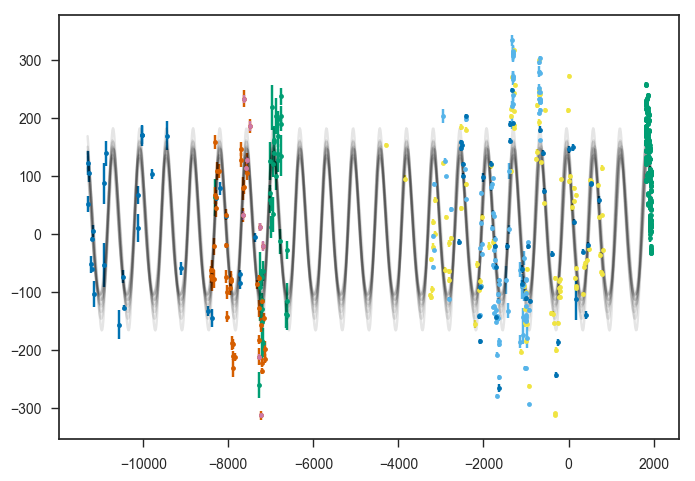

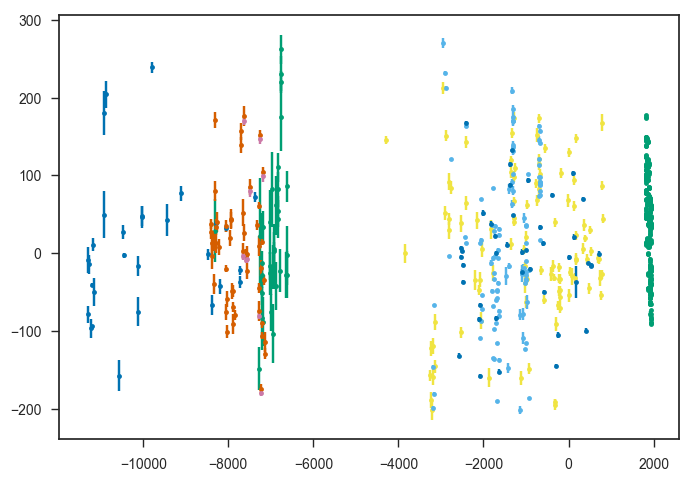

In [34]:
for i in 1:10
    p = psar1[rand(1:size(psar1,1))]
    tplot = collect(linspace(tmin, tmax, 1000))
    rvs = [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in tplot]
    plot(tplot, rvs, color="k", alpha=0.1)
end
mus = mean(hcat([p.mu for p in psar1]...), 2)
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-mus[i], dys[i], fmt=".")
end
figure()
p = psar1[rand(1:size(psar1, 1))]
for i in eachindex(ts)
    errorbar(ts[i], ys[i]-p.mu[i]-[Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts[i]], dys[i]*p.nu[i], fmt=".")
end

What do the whitened residuals look like?

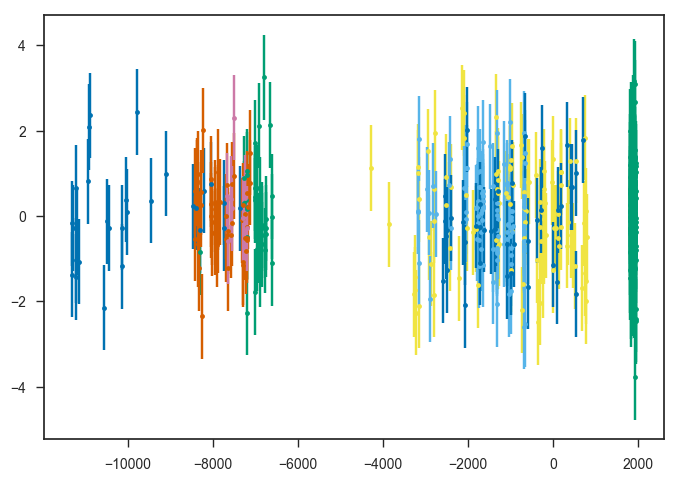

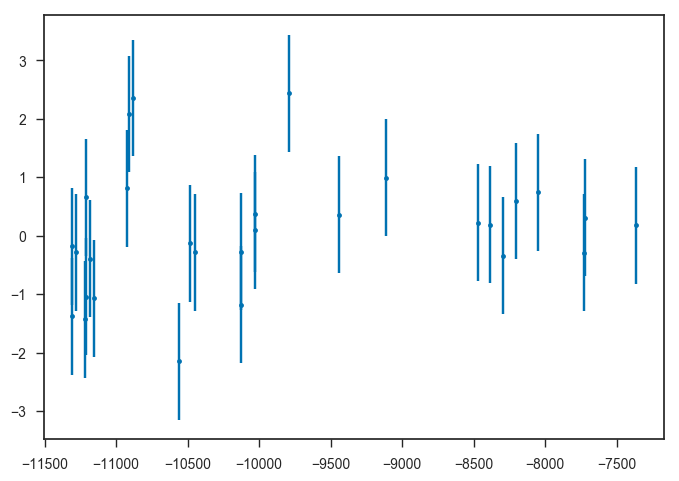

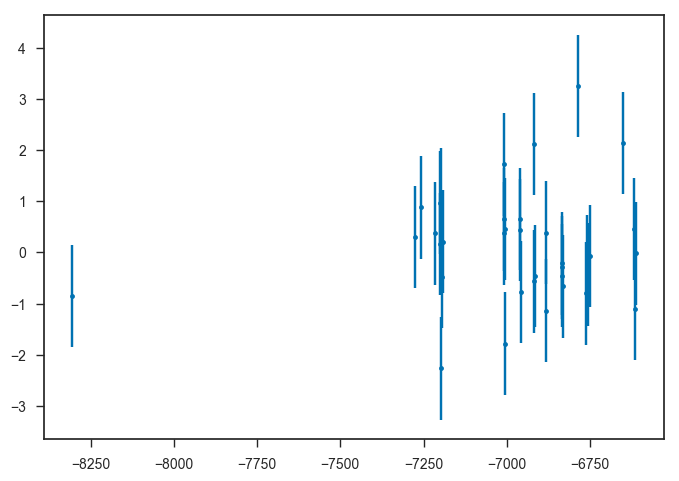

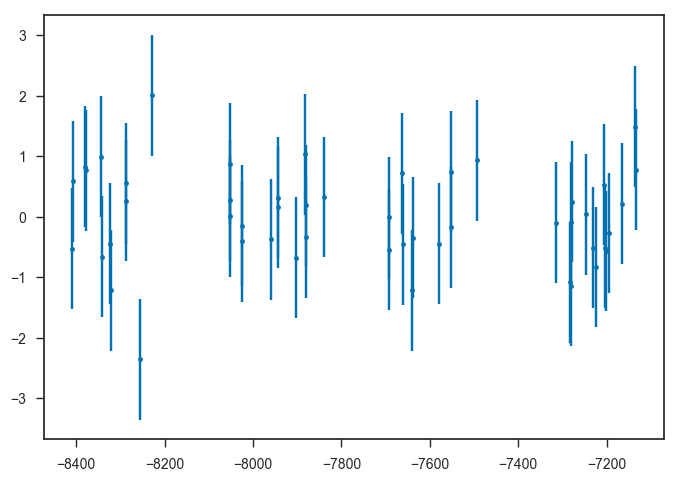

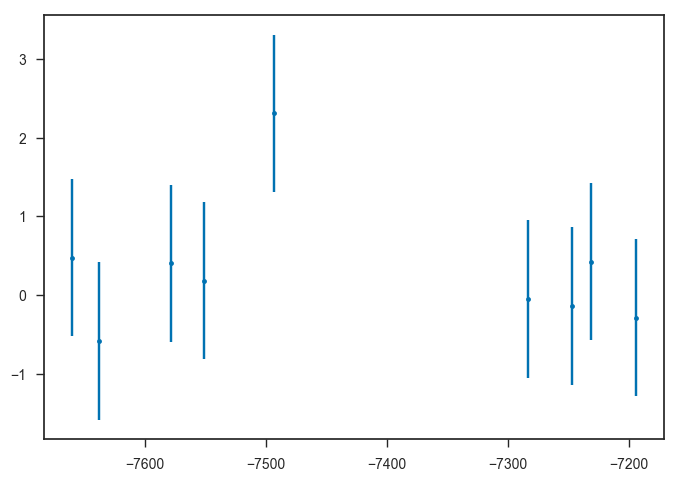

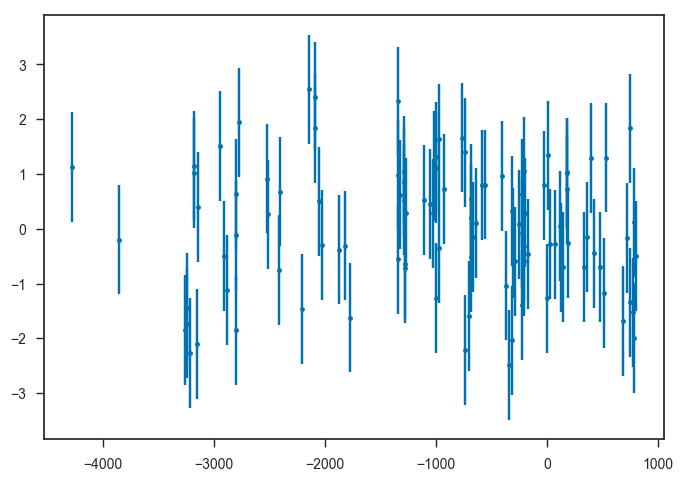

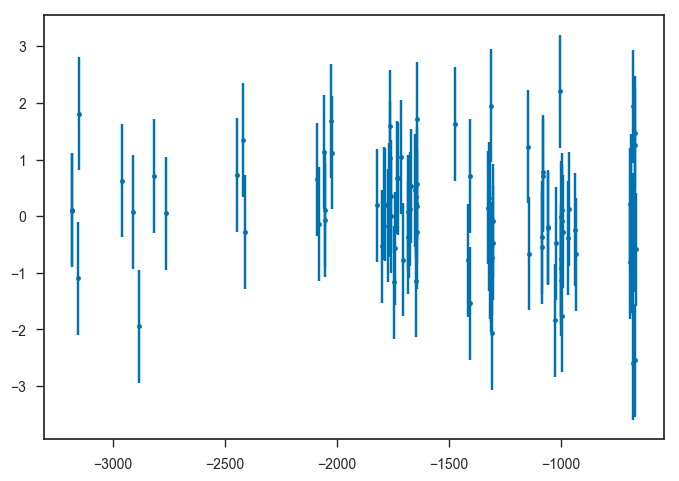

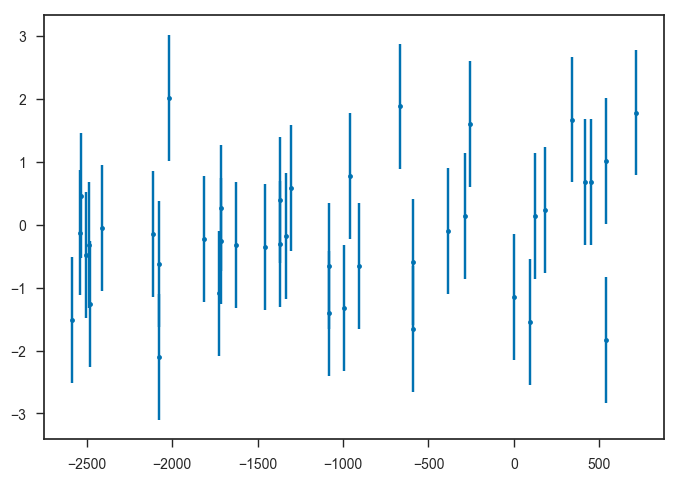

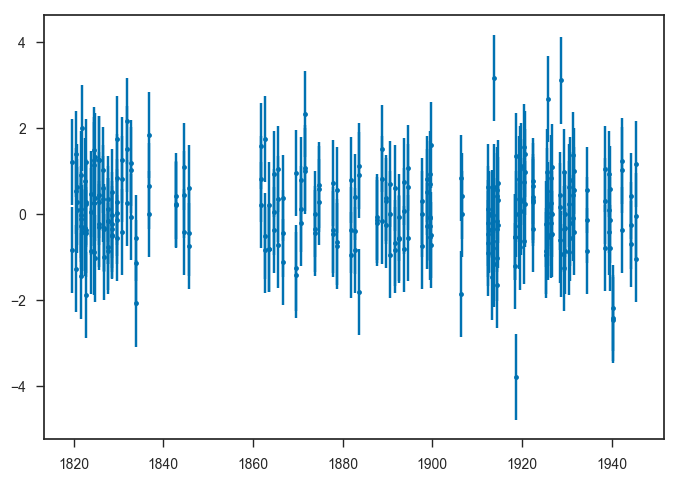

In [35]:
p = psar1[rand(1:size(psar1,1))]
wrs = kepler_ar1_white_residuals(p)
for i in eachindex(ts)
    errorbar(ts[i], wrs[i], ones(size(wrs[i],1)), fmt=".")
end
for i in eachindex(ts)
    figure()
    errorbar(ts[i], wrs[i], ones(size(wrs[i],1)), fmt=".")
end

## Keplerian Plus Full CARMA (1 Frequency)

Here we switch to NestedSampling; the MCMC seems to take a very long time to converge, and we would like in any case to weigh the evidence between the various numbers of mode terms.  (I interrupted the run below, and ran the same code in a Julia terminal because the output is very long, and not needed in the notebook.)

In [29]:
post1 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0)
ns1 = EnsembleNest.NestState(x -> CARMAKepler.log_likelihood(post1, x), x -> CARMAKepler.log_prior(post1, x), CARMAKepler.draw_prior(post1, 1024), 128)
EnsembleNest.run!(ns1, 0.01, verbose=true, ckpt_file="/tmp/ns1.ckpt")

CARMAKepler.MultiEpochPosterior(Array{Float64,1}[[-11307.9, -11306.8, -11279.9, -11217.1, -11210.2, -11209.2, -11185.0, -11152.2, -10924.9, -10912.0  …  -9444.98, -9111.96, -8466.86, -8383.9, -8293.12, -8202.25, -8049.86, -7725.83, -7724.84, -7366.81], [-8305.26, -7275.07, -7258.1, -7217.13, -7200.24, -7199.27, -7198.21, -7197.24, -7195.33, -7191.25  …  -6832.31, -6785.37, -6761.33, -6759.32, -6757.33, -6749.32, -6651.94, -6618.91, -6613.9, -6612.9], [-8408.97, -8408.08, -8379.02, -8378.17, -8343.1, -8342.14, -8322.16, -8321.14, -8287.25, -8286.35  …  -7247.26, -7231.22, -7225.1, -7207.14, -7203.16, -7202.14, -7194.18, -7166.24, -7135.33, -7134.35], [-7660.01, -7637.96, -7578.22, -7551.16, -7493.33, -7282.98, -7247.28, -7231.22, -7194.18], [-4280.2, -3854.39, -3261.98, -3241.07, -3240.05, -3217.09, -3179.22, -3177.24, -3150.24, -3149.35  …  512.688, 533.688, 687.031, 723.051, 749.938, 754.063, 775.84, 785.809, 786.824, 801.754], [-3183.75, -3182.74, -3155.75, -3153.71, -2961.41, -2909.

In [59]:
ns1 = h5open("/tmp/ns1.ckpt", "r") do f
    EnsembleNest.NestState(f, logl=(x -> CARMAKepler.log_likelihood(post1, x)), logp=(x -> CARMAKepler.log_prior(post1, x)))
end
liveps = [CARMAKepler.to_params(post1, ns1.livepts[:,j]) for j in 1:size(ns1.livepts,2)];

In [63]:
postck, lnprobsck = EnsembleNest.postsample(ns1)

([51.4128 87.4346 … 14.8505 34.8333; 0.399038 0.0197743 … 0.233742 0.560163; … ; -1.31729 -1.26279 … -1.27888 -1.28505; -6.37631 -6.23763 … -6.04281 -6.8766], [-2951.69, -2951.5, -2950.83, -2950.75, -2950.53, -2949.91, -2949.68, -2949.59, -2948.97, -2948.93  …  -2928.75, -2931.19, -2931.17, -2930.53, -2930.81, -2931.21, -2930.29, -2931.28, -2930.92, -2930.22])

In [64]:
psck = CARMAKepler.MultiEpochParams[]
for j in 1:size(postck, 2)
        push!(psck, CARMAKepler.to_params(post1, postck[:,j]))
end

In [65]:
h5open("carma-1-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns1)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in psck]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in psck]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in psck]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in psck]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in psck]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in psck]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in psck]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in psck]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in psck]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in psck]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in psck]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in psck]...)
end;

In [86]:
psck, ns1 = h5open("carma-1-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post1, x)), logp=(x->CARMAKepler.log_prior(post1,x))))
end;

Let's check the frequencies.

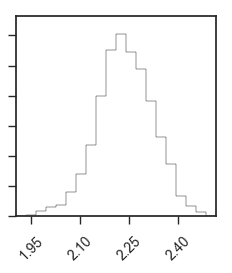

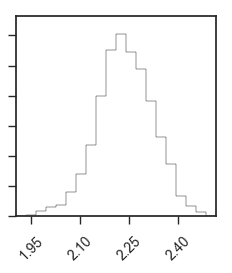

In [89]:
corner.corner(vcat([p.osc_freq'/muHz for p in psck]...))

And now a few plots of the Kepler parameters:

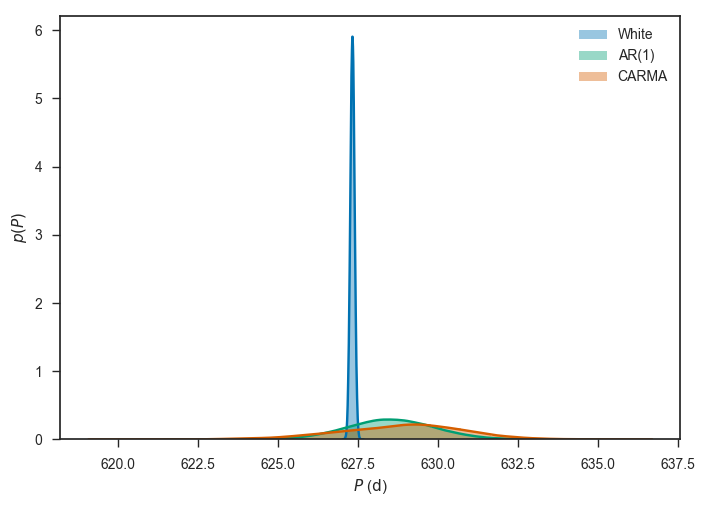

PyObject <matplotlib.text.Text object at 0x15c6da710>

In [90]:
sns.distplot([p.P for p in ps], label="White")
sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")

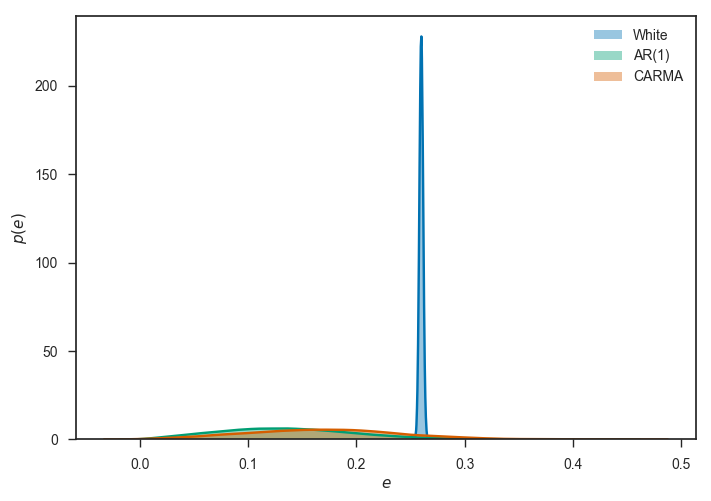

PyObject <matplotlib.text.Text object at 0x168e12cc0>

In [91]:
sns.distplot([p.e for p in ps], label="White")
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$e$")
ylabel(L"$p(e)$")

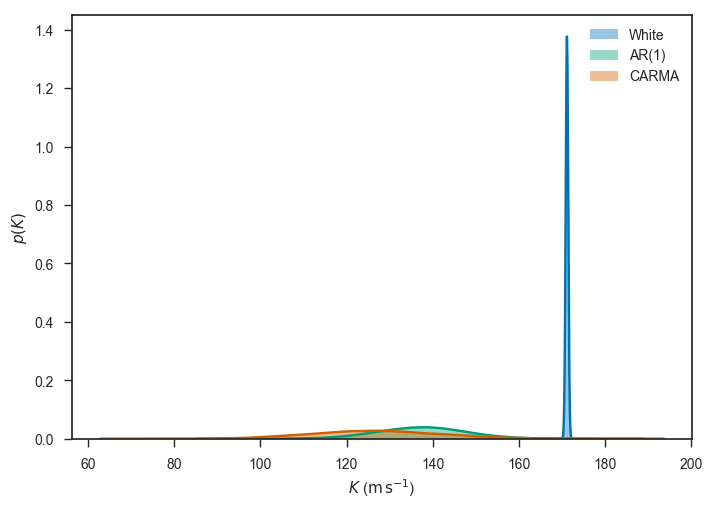

PyObject <matplotlib.text.Text object at 0x1697d42b0>

In [92]:
sns.distplot([p.K for p in ps], label="White")
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(K)$")

How about a zoom in on the PSD for the CARMA process around $2 \, \mu\mathrm{Hz}$?

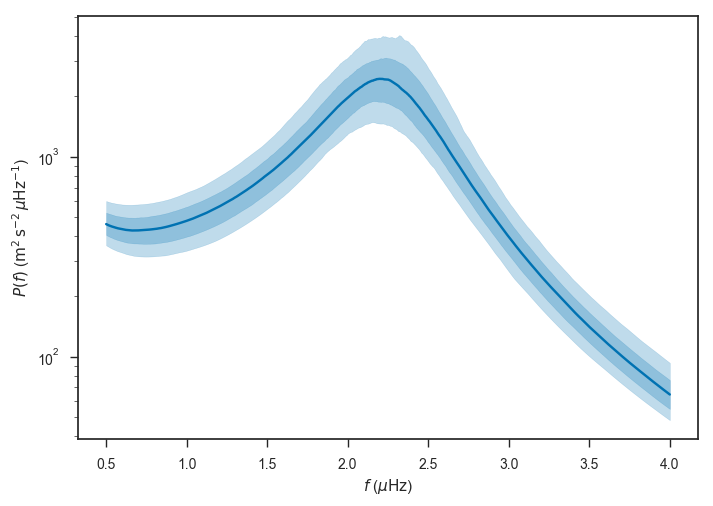

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[93]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
wh

PyObject <matplotlib.text.Text object at 0x16a104d30>

In [93]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(psck, 1024))
    psds[:,i] = CARMAKepler.psd(post1, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

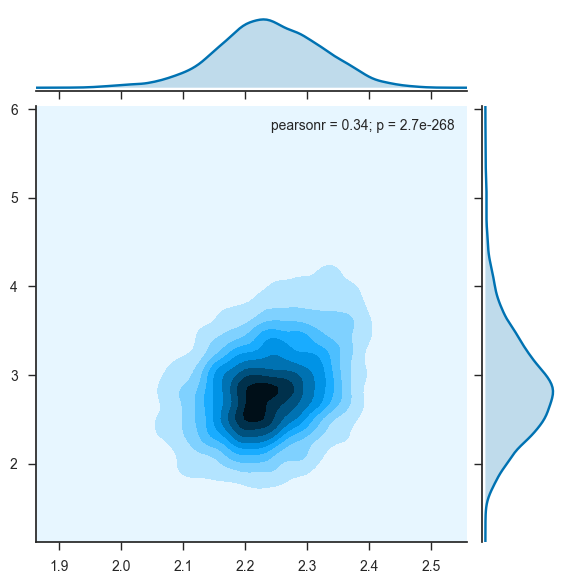

PyObject <seaborn.axisgrid.JointGrid object at 0x15d41ef98>

In [94]:
sns.jointplot(vcat([p.osc_freq/muHz for p in psck]...), vcat([p.osc_Q for p in psck]...), kind="kde")

The scale factors on the errorbars:

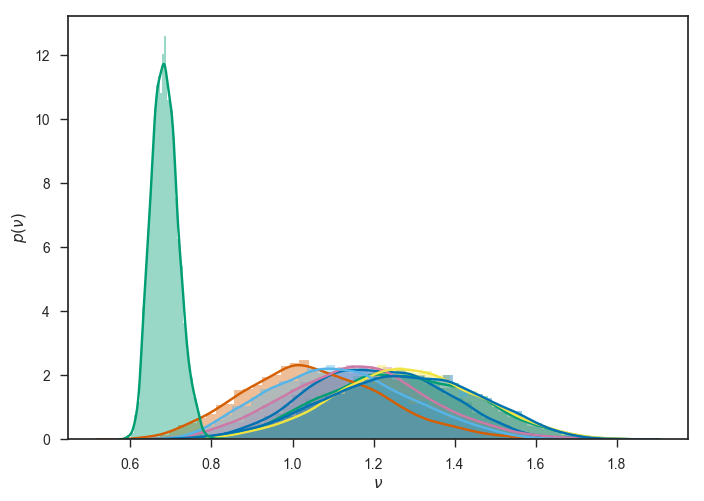

PyObject <matplotlib.text.Text object at 0x16048e8d0>

In [95]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psck])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

In [97]:
function uncertainty_triple(xs)
    xmed = median(xs)
    xplus = quantile(xs, 0.84) - xmed
    xminus = xmed - quantile(xs, 0.16)
    return xmed, xplus, xminus
end

println(@sprintf("P = %.1f + %.1f - %.1f d", uncertainty_triple([p.P for p in psck])...))
println(@sprintf("e = %.3f + %.3f - %.3f", uncertainty_triple([p.e for p in psck])...))
println(@sprintf("K = %.0f + %.0f - %.0f m/s", uncertainty_triple([p.K for p in psck])...))
println(@sprintf("numax = %.3f + %.3f - %.3f muHz", uncertainty_triple([p.osc_freq[1]/muHz for p in psck])...))

P = 629.0 + 1.7 - 2.1 d
e = 0.168 + 0.069 - 0.071
K = 127 + 15 - 14 m/s
numax = 2.238 + 0.086 - 0.080 muHz


## Keplerian Plus Full CARMA (2 Frequencies)

In [98]:
post2 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 2, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0)

CARMAKepler.MultiEpochPosterior(Array{Float64,1}[[-11307.9, -11306.8, -11279.9, -11217.1, -11210.2, -11209.2, -11185.0, -11152.2, -10924.9, -10912.0  …  -9444.98, -9111.96, -8466.86, -8383.9, -8293.12, -8202.25, -8049.86, -7725.83, -7724.84, -7366.81], [-8305.26, -7275.07, -7258.1, -7217.13, -7200.24, -7199.27, -7198.21, -7197.24, -7195.33, -7191.25  …  -6832.31, -6785.37, -6761.33, -6759.32, -6757.33, -6749.32, -6651.94, -6618.91, -6613.9, -6612.9], [-8408.97, -8408.08, -8379.02, -8378.17, -8343.1, -8342.14, -8322.16, -8321.14, -8287.25, -8286.35  …  -7247.26, -7231.22, -7225.1, -7207.14, -7203.16, -7202.14, -7194.18, -7166.24, -7135.33, -7134.35], [-7660.01, -7637.96, -7578.22, -7551.16, -7493.33, -7282.98, -7247.28, -7231.22, -7194.18], [-4280.2, -3854.39, -3261.98, -3241.07, -3240.05, -3217.09, -3179.22, -3177.24, -3150.24, -3149.35  …  512.688, 533.688, 687.031, 723.051, 749.938, 754.063, 775.84, 785.809, 786.824, 801.754], [-3183.75, -3182.74, -3155.75, -3153.71, -2961.41, -2909.

In [171]:
ns2 = h5open("/tmp/ns2.ckpt", "r") do f
    EnsembleNest.NestState(f, logl=(x -> CARMAKepler.log_likelihood(post2, x)), logp=(x -> CARMAKepler.log_prior(post2, x)))
end
liveps = [CARMAKepler.to_params(post2, ns2.livepts[:,j]) for j in 1:size(ns2.livepts,2)];

In [143]:
postck, lnprobsck = EnsembleNest.postsample(ns2)

([-30.2923 23.8877 … 70.2282 -84.2581; 0.0442805 0.601903 … -1.25317 -0.251341; … ; -1.38094 -1.50123 … -1.21167 -1.34291; -5.93991 -6.60123 … -5.49969 -6.38294], [-2942.13, -2944.29, -2945.09, -2944.55, -2946.34, -2944.88, -2943.02, -2945.2])

In [144]:
psck = CARMAKepler.MultiEpochParams[]
for j in 1:size(postck, 2)
        push!(psck, CARMAKepler.to_params(post2, postck[:,j]))
end

In [145]:
psck

8-element Array{CARMAKepler.MultiEpochParams,1}:
 CARMAKepler.MultiEpochParams([-30.2923, -26.4762, -12.9143, -49.5672, 9.77832, 7.44786, 10.211, 54474.0], [1.2666, 1.54131, 1.34746, 1.45602, 1.10566, 1.30708, 1.20194, 0.692159], 117.006, 631.221, 0.297994, -0.6955, 0.866975, [99.1001], [0.00304677], [1.44509, 57.9014], [0.0270868, 0.195187], [329.13, 3.62274])       
 CARMAKepler.MultiEpochParams([23.8877, 15.5139, -5.78644, -47.9911, 9.83682, 10.2393, 19.3163, 54317.3], [1.46914, 0.896544, 1.05331, 1.12075, 1.0428, 1.41713, 0.921028, 0.724775], 95.6735, 628.437, 0.299421, -0.794393, 0.879046, [88.0795], [0.00394235], [0.971682, 56.9944], [0.0443254, 0.193705], [273.152, 2.35549])  
 CARMAKepler.MultiEpochParams([123.461, -20.4121, 51.1495, 5.50105, 11.4322, 9.89711, 18.1668, 54274.1], [0.789214, 1.05982, 1.08767, 1.243, 0.921491, 1.05035, 1.40143, 0.690228], 141.95, 630.847, 0.312279, -0.879472, 0.843605, [101.414], [0.00279375], [8.21387, 53.0309], [0.033304, 0.194408], [1.53382, 2.

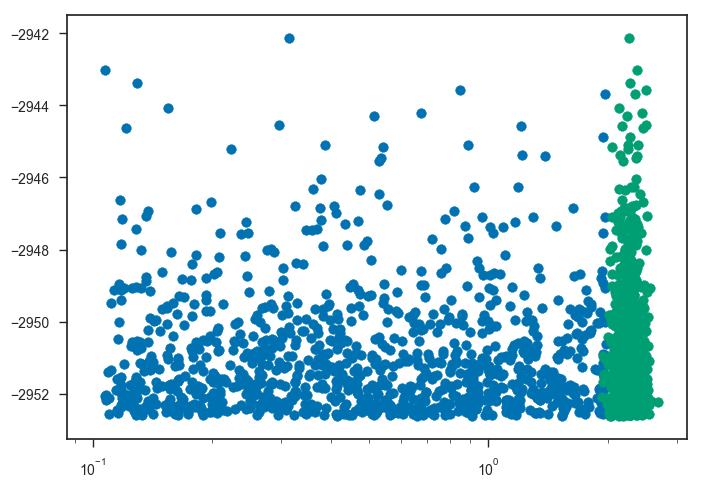

In [168]:
scatter([p.osc_freq[1]/muHz for p in liveps], ns2.livelogls)
scatter([p.osc_freq[2]/muHz for p in liveps], ns2.livelogls)
xscale("log")

In [177]:
xs = CARMAKepler.draw_prior(post2, 128)
logpost = (x -> CARMAKepler.log_likelihood(post2, x) + CARMAKepler.log_prior(post2, x))
lnprobs = EnsembleSampler.lnprobs(xs, logpost);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_prior(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:190
 [4] log_prior(::CARMAKepler.MultiEpochPosterior, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:173
 [5] lnprobs(::Array{Float64,2}, ::##495#496) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[177], in expression starting on line 3


In [178]:
xs, lnprobs = EnsembleSampler.run_to_neff(xs, lnprobs, logpost, 16, callback=cb)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_prior(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:190
 [4] log_prior(::CARMAKepler.MultiEpochPosterior, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:173
 [5] lnprobs(::Array{Float64,2}, ::##495#496) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:37
 [6] update_half(::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:69
 [7] update(::Array{Float64,2}, ::Array{Float64,1}, ::Function) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:110
 [8] #run_mcmc#1(::Int64, ::Function, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:129
 [9] (::Ensemble.EnsembleSampler.#kw##run_mcmc)(::Array{A

Advanced for 128 steps (thin = 1); (max, mean, var)(log(pi)) = (-3169.4, -35274.7, 77837860489.1)
    ACLs are [10.6,Inf,11.8,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,5.5,Inf,Inf,Inf,11.6,Inf,Inf,Inf,Inf,11.0,Inf,Inf,Inf,11.9,9.6,6.6]


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70


    acceptance fraction = 0.328


 [2] log1p(::Array{Float64,1}) at ./deprecated.jl:57
 [3] cb(::Array{Float64,3}, ::Array{Float64,2}, ::Int64, ::Int64) at ./In[167]:7
 [4] #run_to_neff#4(::#cb, ::Function, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at /Users/farr/.julia/v0.6/Ensemble/src/EnsembleSampler.jl:191
 [5] (::Ensemble.EnsembleSampler.#kw##run_to_neff)(::Array{Any,1}, ::Ensemble.EnsembleSampler.#run_to_neff, ::Array{Float64,2}, ::Array{Float64,1}, ::Function, ::Int64) at ./<missing>:0
 [6] include_string(::String, ::String) at ./loading.jl:522
 [7] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [9] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##14#17)() at ./task.jl:335
while loading In[178], in expression starting on line 1


Advanced for 128 steps (thin = 1); (max, mean, var)(log(pi)) = (-3145.5, -3309.3, 140300.8)
    ACLs are [Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,9.3,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf]
    acceptance fraction = 0.251
Advanced for 128 steps (thin = 1); (max, mean, var)(log(pi)) = (-3144.2, -3157.8, 27.6)
    ACLs are [8.2,Inf,Inf,Inf,2.1,Inf,1.9,Inf,Inf,4.9,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf]
    acceptance fraction = 0.244
Advanced for 256 steps (thin = 2); (max, mean, var)(log(pi)) = (-3130.7, -3149.7, 34.5)
    ACLs are [Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,4.0,Inf,4.1,Inf,4.2,Inf,Inf,7.3,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf]
    acceptance fraction = 0.230
Advanced for 128 steps (thin = 1); (max, mean, var)(log(pi)) = (-3129.0, -3144.7, 31.2)
    ACLs are [Inf,Inf,Inf,Inf,11.5,Inf,11.6,Inf,6.3,Inf,5.9,Inf,6.5,Inf,Inf,Inf,Inf,10.0,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf]
    acceptance fracti

LoadError: [91mInterruptException:[39m

In [189]:
xs = h5open("/tmp/state.save.h5", "r") do f
    read(f, "pts")
end;
ps = [CARMAKepler.to_params(post2, xs[:,j,k]) for j in 1:size(xs, 2) for k in 1:size(xs,3)];

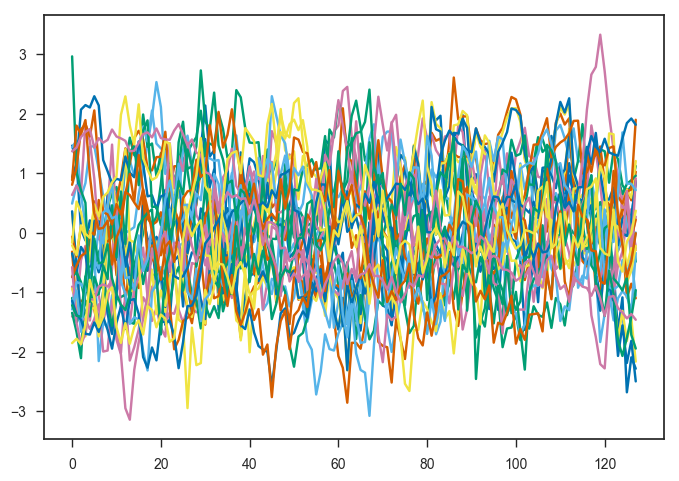

In [199]:
mus = squeeze(mean(xs, 2), 2)
mu = squeeze(mean(mus, 2), 2)
sigma = squeeze(std(mus, 2), 2)
for i in 1:size(mus, 1)
    plot((vec(mus[i,:]) - mu[i])/sigma[i])
end

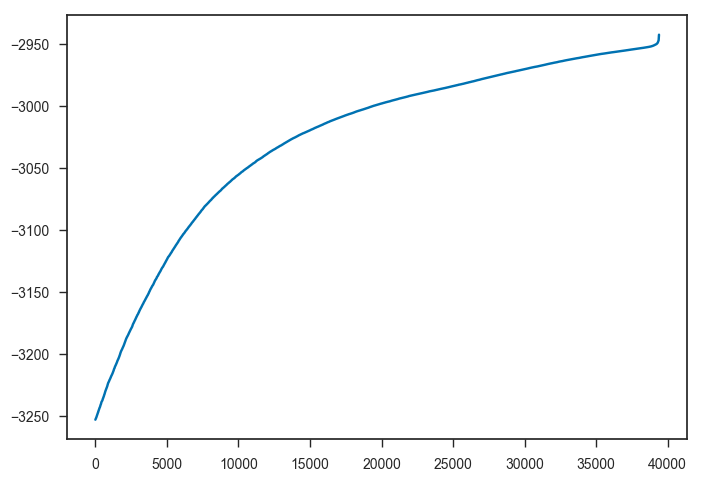

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1652423c8>

In [147]:
plot(vcat(ns2.deadlogls[20000:end], sort(ns2.livelogls)))

In [65]:
h5open("carma-2-kepler.h5", "w") do f
    nsg = g_create(f, "nest_state")
    write(nsg, ns2)
    
    f["mu", "shuffle", (), "compress", 3] = vcat([p.mu' for p in psck]...)
    f["nu", "shuffle", (), "compress", 3] = vcat([p.nu' for p in psck]...)
    f["K", "shuffle", (), "compress", 3] = [p.K for p in psck]
    f["P", "shuffle", (), "compress", 3] = [p.P for p in psck]
    f["e", "shuffle", (), "compress", 3] = [p.e for p in psck]
    f["omega", "shuffle", (), "compress", 3] = [p.omega for p in psck]
    f["chi", "shuffle", (), "compress", 3] = [p.chi for p in psck]
    
    f["drw_rms", "shuffle", (), "compress", 3] = vcat([p.drw_rms' for p in psck]...)
    f["drw_rate", "shuffle", (), "compress", 3] = vcat([p.drw_rate' for p in psck]...)

    f["osc_rms", "shuffle", (), "compress", 3] = vcat([p.osc_rms' for p in psck]...)
    f["osc_freq", "shuffle", (), "compress", 3] = vcat([p.osc_freq' for p in psck]...)
    f["osc_Q", "shuffle", (), "compress", 3] = vcat([p.osc_Q' for p in psck]...)
end;

In [179]:
psck, ns2 = h5open("carma-2-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rms = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rms = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    ([CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rms[:,i], drw_rates[:,i], osc_rms[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in eachindex(Ps)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post2, x)), logp=(x->CARMAKepler.log_prior(post2,x))))
end;

Let's check the frequencies.

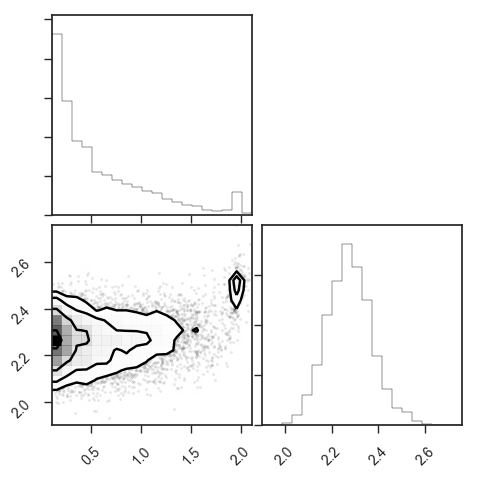

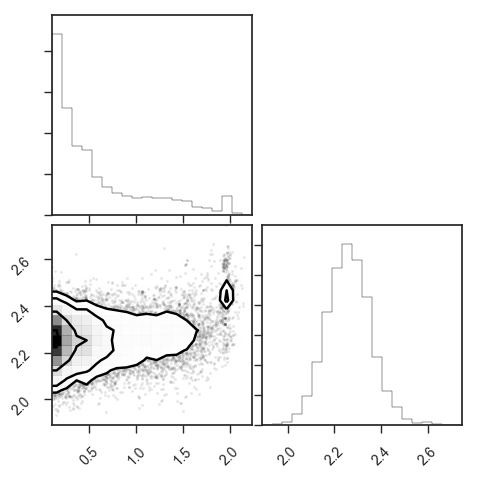

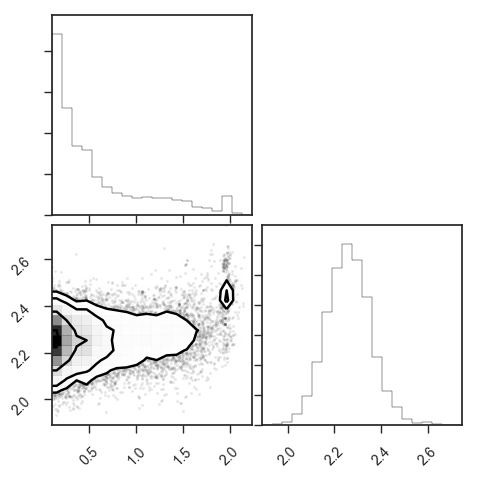

In [191]:
corner.corner(vcat([p.osc_freq'/muHz for p in psck]...))
corner.corner(vcat([p.osc_freq'/muHz for p in ps]...))

And now a few plots of the Kepler parameters:

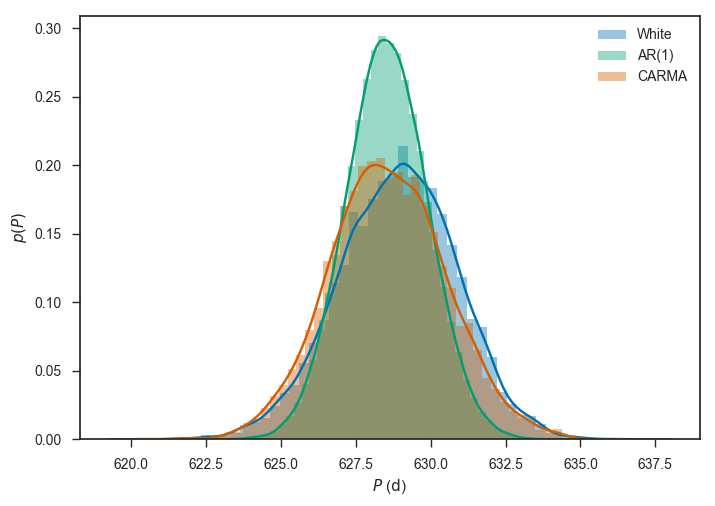

PyObject <matplotlib.text.Text object at 0x16a480438>

In [193]:
sns.distplot([p.P for p in ps], label="White")
sns.distplot([p.P for p in psar1], label="AR(1)")
sns.distplot([p.P for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$P$ ($\mathrm{d}$)")
ylabel(L"$p(P)$")

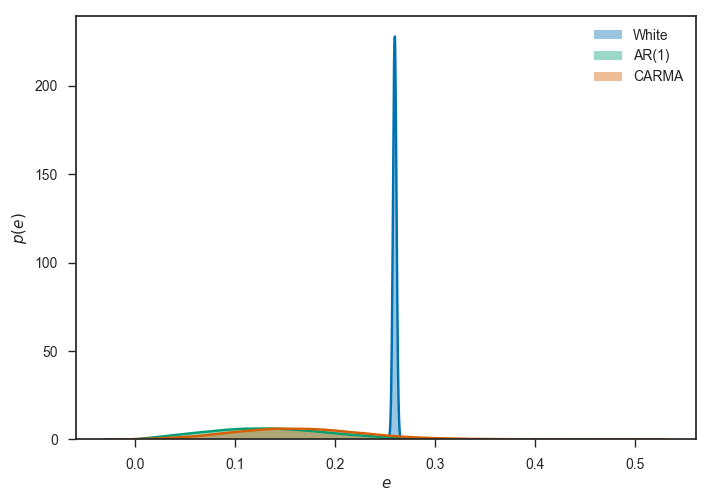

PyObject <matplotlib.text.Text object at 0x16e7579e8>

In [182]:
sns.distplot([p.e for p in ps], label="White")
sns.distplot([p.e for p in psar1], label="AR(1)")
sns.distplot([p.e for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$e$")
ylabel(L"$p(e)$")

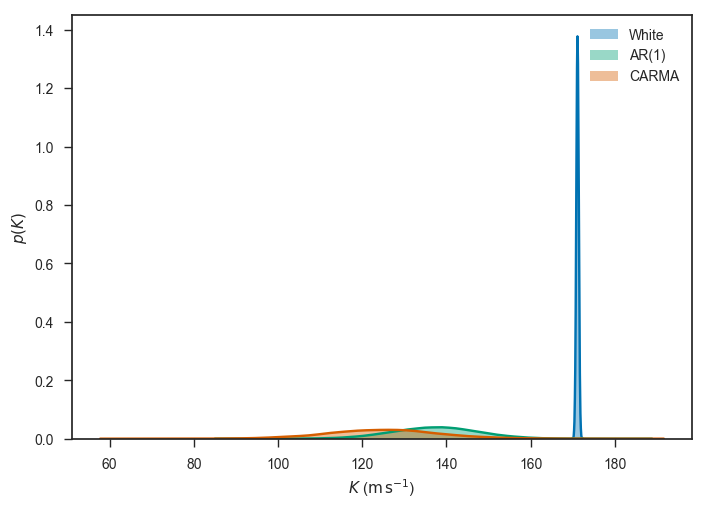

PyObject <matplotlib.text.Text object at 0x166f48630>

In [183]:
sns.distplot([p.K for p in ps], label="White")
sns.distplot([p.K for p in psar1], label="AR(1)")
sns.distplot([p.K for p in psck], label="CARMA")
legend(loc="best")
xlabel(L"$K$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(K)$")

How about a zoom in on the PSD for the CARMA process around $2 \, \mu\mathrm{Hz}$?

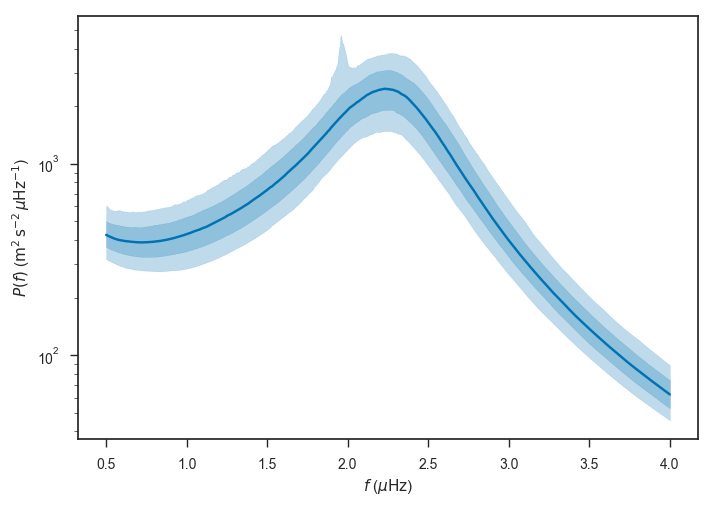

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[184]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

PyObject <matplotlib.text.Text object at 0x16f85c0f0>

In [184]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(psck, 1024))
    psds[:,i] = CARMAKepler.psd(post2, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")

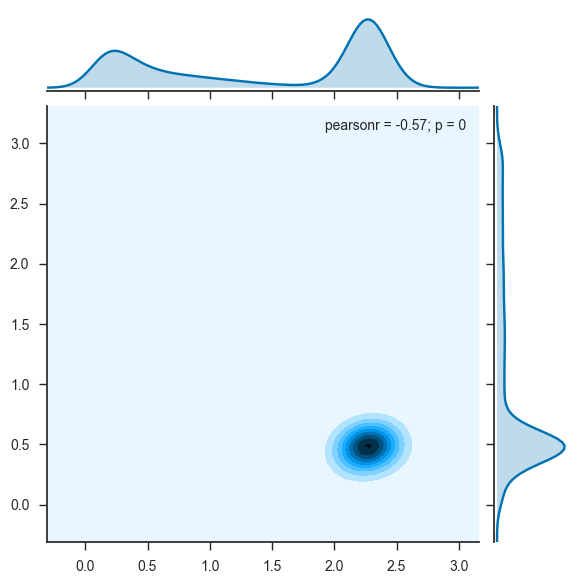

PyObject <seaborn.axisgrid.JointGrid object at 0x1666ebbe0>

In [186]:
sns.jointplot(vcat([p.osc_freq/muHz for p in psck]...), log10.(vcat([p.osc_Q for p in psck]...)), kind="kde")

The scale factors on the errorbars:

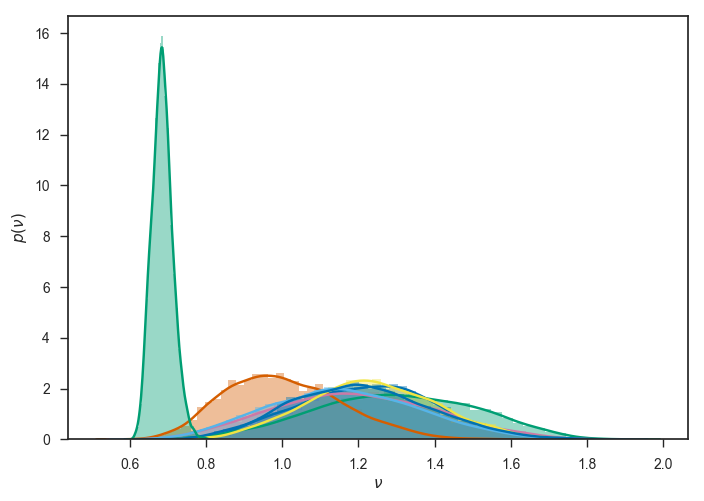

PyObject <matplotlib.text.Text object at 0x16c0a4ef0>

In [187]:
for i in eachindex(ts)
    sns.distplot([p.nu[i] for p in psck])
end
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

In [188]:
function uncertainty_triple(xs)
    xmed = median(xs)
    xplus = quantile(xs, 0.84) - xmed
    xminus = xmed - quantile(xs, 0.16)
    return xmed, xplus, xminus
end

println(@sprintf("P = %.1f + %.1f - %.1f d", uncertainty_triple([p.P for p in psck])...))
println(@sprintf("e = %.3f + %.3f - %.3f", uncertainty_triple([p.e for p in psck])...))
println(@sprintf("K = %.0f + %.0f - %.0f m/s", uncertainty_triple([p.K for p in psck])...))
println(@sprintf("numax = %.3f + %.3f - %.3f muHz", uncertainty_triple([p.osc_freq[2]/muHz for p in psck])...))

P = 628.5 + 2.0 - 1.9 d
e = 0.161 + 0.066 - 0.062
K = 125 + 13 - 13 m/s
numax = 2.273 + 0.093 - 0.093 muHz


## Keplerian Plus Full CARMA (3 Frequencies)

In [201]:
post3 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 3, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0)

CARMAKepler.MultiEpochPosterior(Array{Float64,1}[[-11307.9, -11306.8, -11279.9, -11217.1, -11210.2, -11209.2, -11185.0, -11152.2, -10924.9, -10912.0  …  -9444.98, -9111.96, -8466.86, -8383.9, -8293.12, -8202.25, -8049.86, -7725.83, -7724.84, -7366.81], [-8305.26, -7275.07, -7258.1, -7217.13, -7200.24, -7199.27, -7198.21, -7197.24, -7195.33, -7191.25  …  -6832.31, -6785.37, -6761.33, -6759.32, -6757.33, -6749.32, -6651.94, -6618.91, -6613.9, -6612.9], [-8408.97, -8408.08, -8379.02, -8378.17, -8343.1, -8342.14, -8322.16, -8321.14, -8287.25, -8286.35  …  -7247.26, -7231.22, -7225.1, -7207.14, -7203.16, -7202.14, -7194.18, -7166.24, -7135.33, -7134.35], [-7660.01, -7637.96, -7578.22, -7551.16, -7493.33, -7282.98, -7247.28, -7231.22, -7194.18], [-4280.2, -3854.39, -3261.98, -3241.07, -3240.05, -3217.09, -3179.22, -3177.24, -3150.24, -3149.35  …  512.688, 533.688, 687.031, 723.051, 749.938, 754.063, 775.84, 785.809, 786.824, 801.754], [-3183.75, -3182.74, -3155.75, -3153.71, -2961.41, -2909.

In [535]:
ns3 = h5open("/tmp/ns3.ckpt", "r") do f
    EnsembleNest.NestState(f, logp=(x->CARMAKepler.log_prior(post3, x)), logl=(x->CARMAKepler.log_likelihood(post3,x)))
end;

In [536]:
xs, lnps = EnsembleNest.postsample(ns3)

([223.869 54.6405 … 53.2835 15.9422; 1.13129 -0.922759 … -0.841519 -0.160692; … ; -2.1045 -1.32365 … -3.44658 -2.03448; -8.8986 -5.84316 … -6.05712 -6.66506], [-2966.25, -2960.12, -2959.12, -2958.85, -2957.88, -2957.57, -2957.46, -2957.36, -2957.23, -2957.17  …  -2929.18, -2929.15, -2929.11, -2929.05, -2928.86, -2928.85, -2927.07, -2927.99, -2928.02, -2926.38])

In [537]:
ps = [CARMAKepler.to_params(post3, xs[:,j]) for j in 1:size(xs, 2)]

9582-element Array{CARMAKepler.MultiEpochParams,1}:
 CARMAKepler.MultiEpochParams([223.869, 210.427, 251.896, 224.048, -100.253, -102.495, -73.2962, 54212.3], [1.63411, 1.26457, 1.10942, 1.25086, 1.19787, 1.00626, 1.15705, 0.592474], 133.843, 627.327, 0.203944, -2.03416, 0.641492, [207.856], [0.000910702], [11.1226, 7.08996, 50.0513], [0.0649707, 0.104486, 0.187014], [136.731, 7.43221, 1.13642])   
 CARMAKepler.MultiEpochParams([54.6405, 96.0077, 105.12, 72.3776, -97.2364, -108.3, -111.469, 54061.3], [0.926594, 1.26391, 1.57599, 1.50799, 0.846008, 1.05311, 1.48641, 0.740507], 102.08, 628.933, 0.282727, -1.86661, 0.701553, [129.831], [0.0020445], [4.69375, 1.11017, 58.8428], [0.0129036, 0.0162282, 0.19444], [1.53843, 1.42095, 3.8884])        
 CARMAKepler.MultiEpochParams([410.739, 435.451, 461.358, 419.625, 99.9725, 95.8462, 109.365, 54102.0], [1.13214, 1.12128, 1.39584, 0.976228, 1.31553, 1.18821, 1.23643, 0.726563], 84.8059, 630.959, 0.114094, -2.24152, 0.642378, [282.829], [0.000462

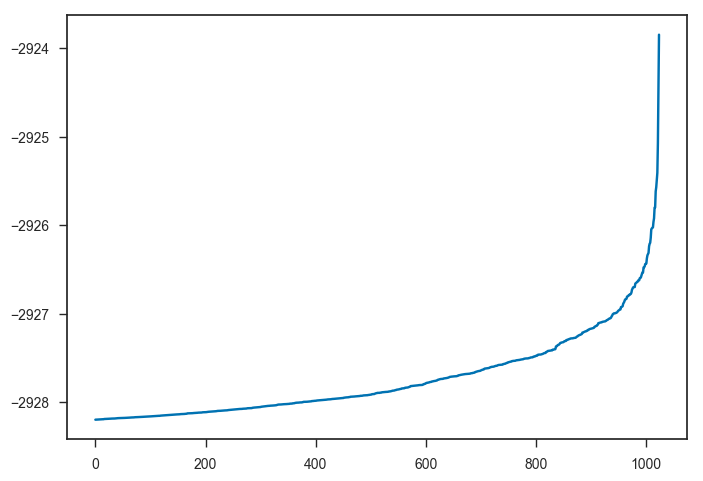

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x16cb78b00>

In [538]:
plot(sort(ns3.livelogls))

In [539]:
maximum(ns3.livelogls)

-2923.8451004391045

In [540]:
liveps = [CARMAKepler.to_params(post3, ns3.livepts[:,j]) for j in 1:size(ns3.livepts, 2)];

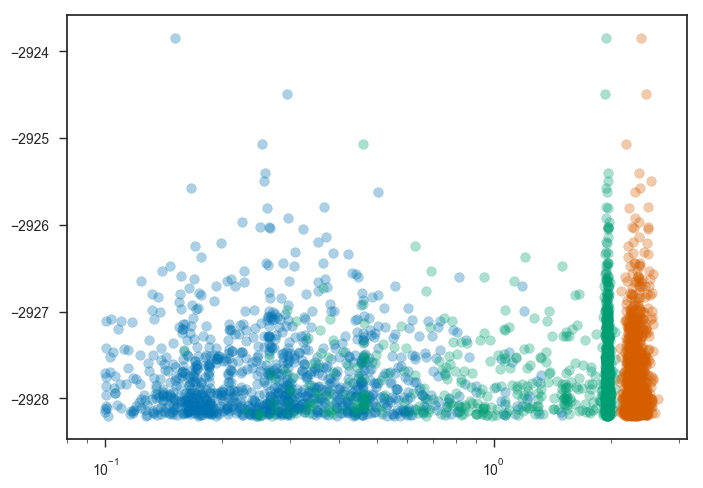

In [541]:
scatter([p.osc_freq[1]/muHz for p in liveps], ns3.livelogls, alpha=0.33)
scatter([p.osc_freq[2]/muHz for p in liveps], ns3.livelogls, alpha=0.33)
scatter([p.osc_freq[3]/muHz for p in liveps], ns3.livelogls, alpha=0.33)
xscale("log")

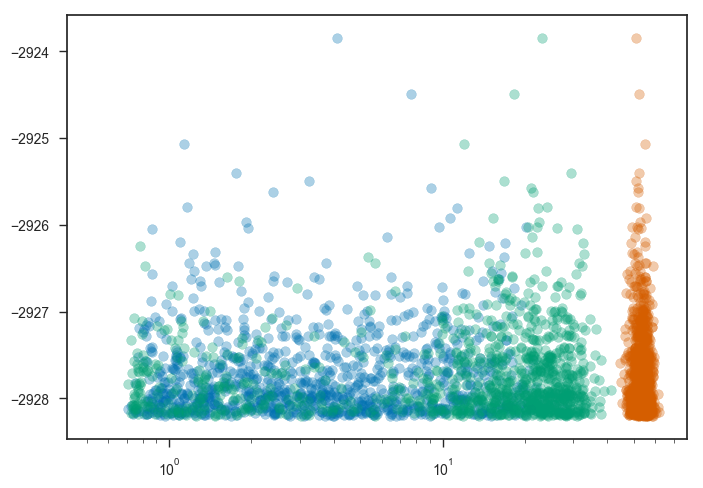

In [542]:
scatter([p.osc_rms[1] for p in liveps], ns3.livelogls, alpha=0.33)
scatter([p.osc_rms[2] for p in liveps], ns3.livelogls, alpha=0.33)
scatter([p.osc_rms[3] for p in liveps], ns3.livelogls, alpha=0.33)
xscale("log")

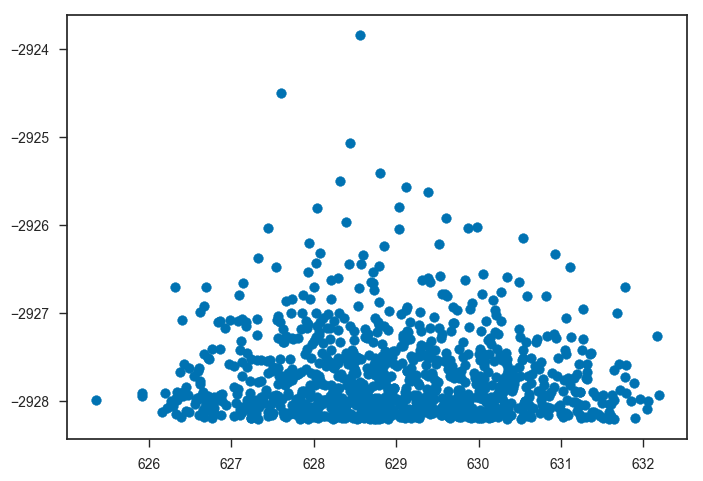

PyObject <matplotlib.collections.PathCollection object at 0x1750d3e48>

In [543]:
scatter([p.P for p in liveps], ns3.livelogls)

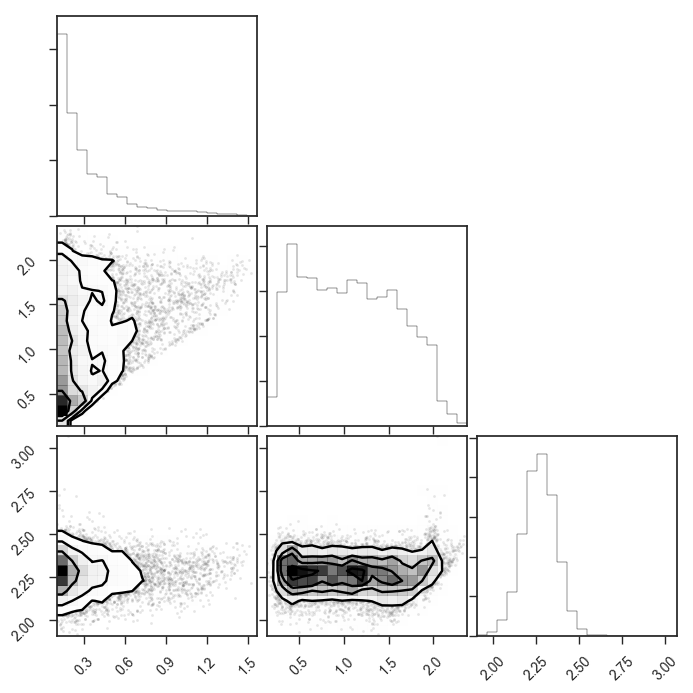

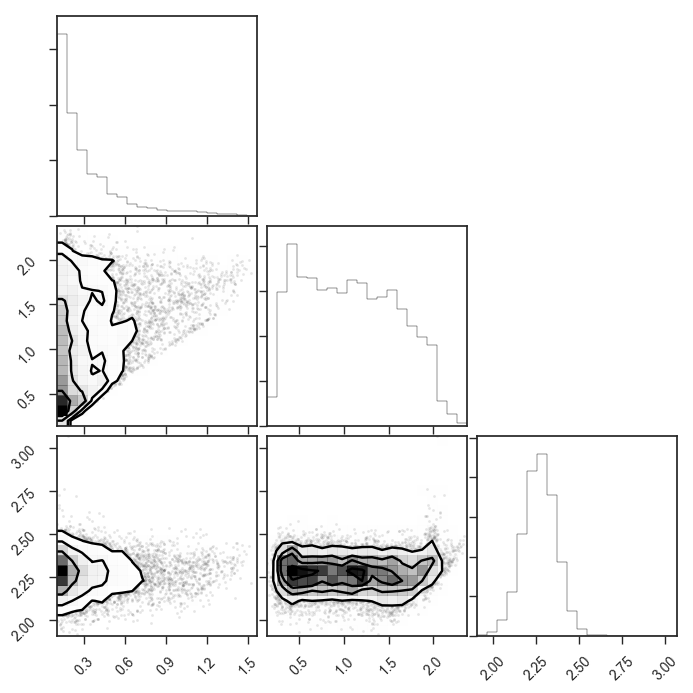

In [544]:
corner.corner(hcat([p.osc_freq/muHz for p in ps]...)')

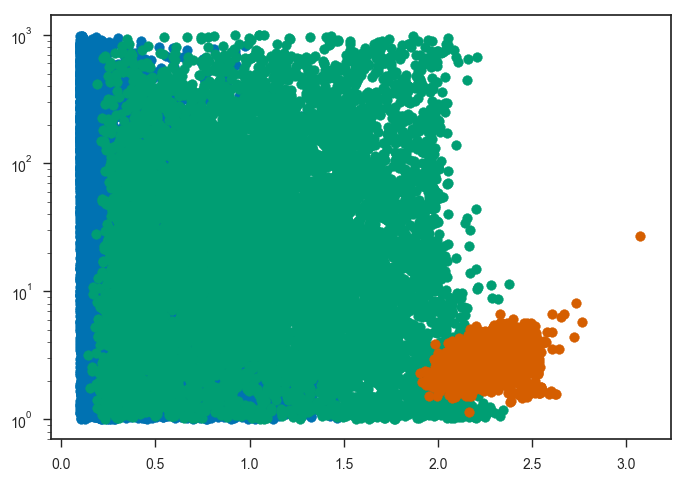

In [546]:
scatter([p.osc_freq[1]/muHz for p in ps], [p.osc_Q[1] for p in ps])
scatter([p.osc_freq[2]/muHz for p in ps], [p.osc_Q[2] for p in ps])
scatter([p.osc_freq[3]/muHz for p in ps], [p.osc_Q[3] for p in ps])
yscale("log")

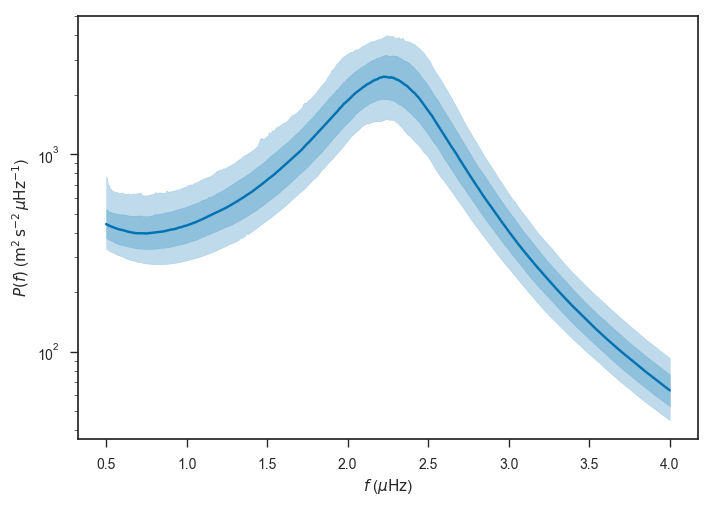

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs2(::Array{Complex{Float64},1}) at ./deprecated.jl:57
 [3] psd_drw(::Float64, ::Float64, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:397
 [4] psd(::CARMA.Celerite.CeleriteKalmanFilter, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/CARMA/src/Celerite.jl:412
 [5] psd(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:350
 [6] macro expansion at ./In[547]:6 [inlined]
 [7] anonymous at ./<missing>:?
 [8] include_string(::String, ::String) at ./loading.jl:522
 [9] include_string(::Module, ::String, ::String) at /Users/farr/.julia/v0.6/Compat/src/Compat.jl:478
 [10] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/farr/.julia/v0.6/IJulia/src/execute_request.jl:154
 [11] eventloop(::ZMQ.Socket) at /Users/farr/.julia/v0.6/IJulia/src/eventloop.jl:8
 [12] (::IJulia.##14#17)() at ./task.jl:335
w

PyObject <matplotlib.text.Text object at 0x17ab99eb8>

In [547]:
nfs = 1000
npost = 1024
fs = collect(linspace(0.5*muHz, 4*muHz, nfs))
psds = zeros(size(fs, 1), npost)
for (i,p) in enumerate(rand(ps, 1024))
    psds[:,i] = CARMAKepler.psd(post3, p, fs)
end
m = zeros(nfs)
h = zeros(nfs)
l = zeros(nfs)
hh = zeros(nfs)
ll = zeros(nfs)

for i in 1:nfs
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    ll[i] = quantile(v, 0.025)
    hh[i] = quantile(v, 0.975)
    h[i] = quantile(v, 0.84)
end

plot(fs/muHz, m*muHz)
fill_between(fs/muHz, h*muHz, l*muHz, color=sns.color_palette()[1], alpha=0.25)
fill_between(fs/muHz, hh*muHz, ll*muHz, color=sns.color_palette()[1], alpha=0.25)

yscale("log")

xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$)")